In [3]:
%pylab inline
import pandas as pd
#import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats 
from scipy.ndimage import gaussian_filter
#sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


# MEAN VECTOR LENGTH

In [4]:
#BINs 6 deg
#SMOOTHING STD=6 deg
def calculateHDtuning(hd,rate):
    x=hd
    y=rate
    nbins=60
    sigma=1
    bad = ~np.logical_or(np.isnan(x), np.isnan(y))
    a=np.compress(bad, x)  
    b=np.compress(bad, y) 
    rawtuning=stats.binned_statistic(a,b, statistic='mean', bins=nbins, range=[0,2*pi])[0]
    smoothedtuning=gaussian_filter(rawtuning,sigma,mode='wrap')
    theta=np.linspace(0,2*pi,nbins)
    return theta,smoothedtuning

def calculateMeanVecLen(hd,rate):
    theta,tuning=calculateHDtuning(hd,rate)
    x=sum(tuning*cos(theta))
    y=sum(tuning*sin(theta))
    mvl=sqrt(pow(x,2)+pow(y,2))/sum(tuning)
    return mvl


In [2]:
#trial data
HD=pd.read_csv("TrialData/HD.csv")
trialMetadata=pd.read_csv("TrialData/metadata.csv",index_col=0)
#cells data
rate=pd.read_csv("CellData/firingRate.csv")
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)
HD.columns=trialMetadata["trialIndex"].values

NameError: name 'pd' is not defined

In [109]:
#CALCULATES MEAN VECTOR LENGTH
meanVecLen=np.zeros(len(rate.T))
for i in range(len(rate.columns)):
        trialId=cellMetadata.loc[rate.columns[i],:]["trialIndex"]
        if cellMetadata["include"][rate.columns[i]]==1:
            x = HD[trialId].values
            y = rate[rate.columns[i]].values 
            meanVecLen[i]=calculateMeanVecLen(x,y)
        else:
            meanVecLen[i]=np.nan
        if i %100==0:
            print("Scored cell: "+str(i))

Scored cell: 0
Scored cell: 100
Scored cell: 200
Scored cell: 300
Scored cell: 400
Scored cell: 500
Scored cell: 600
Scored cell: 700
Scored cell: 800
Scored cell: 900
Scored cell: 1000
Scored cell: 1100
Scored cell: 1200
Scored cell: 1300
Scored cell: 1400
Scored cell: 1500
Scored cell: 1600
Scored cell: 1700
Scored cell: 1800


Text(0,0.5,'# of cells')

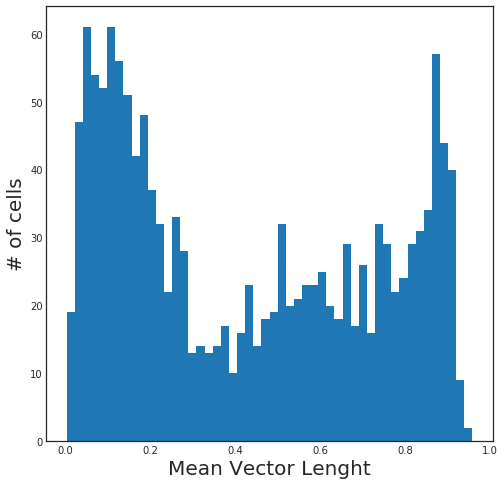

In [100]:
figure(figsize=(8,8))
hist([x for x in meanVecLen if not isnan(x)],bins=50);
xlabel("Mean Vector Lenght",fontsize=20)
ylabel("# of cells",fontsize=20)
#savefig("imgs/speedScore_distr.png")

In [110]:
cellMetadata["meanVecLen"]=meanVecLen

In [111]:
#export
cellMetadata.to_csv("CellData/metadata.csv")

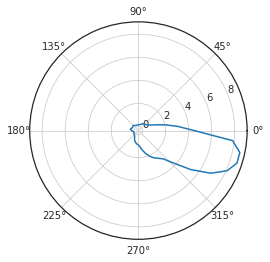

In [93]:
x=HD.values.T[0]
y=frate.values.T[0]
theta,tuning=calculateHDtuning(x,y)
theta=linspace(0,2*pi,60)
#tuning[-1]=tuning[0]
polar(theta,tuning)

# THRESHOLDING

In [112]:
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)
MECspsc=concatenate((np.load("CellData/ShuffledMeanVecLenScoresMEC1.npy"),np.load("CellData/ShuffledMeanVecLenScoresMEC2.npy")))
PaSspsc=concatenate((np.load("CellData/ShuffledMeanVecLenScoresPaS1.npy"),np.load("CellData/ShuffledMeanVecLenScoresPaS2.npy")))
PrSspsc=concatenate((np.load("CellData/ShuffledMeanVecLenScoresPrS1.npy"),np.load("CellData/ShuffledMeanVecLenScoresPrS2.npy")))

In [113]:
MECth=percentile(MECspsc,99)
PaSth=percentile([x for x in PaSspsc if not isnan(x)],99)
PrSth=percentile(PrSspsc,99)

In [115]:
#Add MeanVecLenthreshold to metadata
MeanVecLenTh=[]
MeanVecLenModulated=[]
for i in range(len(cellMetadata.index)):
    if cellMetadata.loc[cellMetadata.index[i]]["region"]=="MEC" and cellMetadata.loc[cellMetadata.index[i]]["include"]==1:
        MeanVecLenTh.append(MECth)
        if cellMetadata.loc[cellMetadata.index[i]]["meanVecLen"]>MECth:
            MeanVecLenModulated.append(1)
        else:
            MeanVecLenModulated.append(0)
        
    elif cellMetadata.loc[cellMetadata.index[i]]["region"]=="PaS" and cellMetadata.loc[cellMetadata.index[i]]["include"]==1:
        MeanVecLenTh.append(PaSth)
        if cellMetadata.loc[cellMetadata.index[i]]["meanVecLen"]>PaSth:
            MeanVecLenModulated.append(1)
        else:
            MeanVecLenModulated.append(0)
    elif cellMetadata.loc[cellMetadata.index[i]]["region"]=="PrS" and cellMetadata.loc[cellMetadata.index[i]]["include"]==1:
        MeanVecLenTh.append(PrSth)
        if cellMetadata.loc[cellMetadata.index[i]]["meanVecLen"]>PrSth:
            MeanVecLenModulated.append(1)
        else:
            MeanVecLenModulated.append(0)
    else:
        MeanVecLenTh.append(np.nan)
        MeanVecLenModulated.append(np.nan)

In [120]:
cellMetadata["meanVecLenTh"]=MeanVecLenTh
cellMetadata["HDmodulated"]=MeanVecLenModulated

In [121]:
#export
cellMetadata.to_csv("CellData/metadata.csv")

In [122]:
#NUMBERS AND PERCENTAGES
tot_cell=len(cellMetadata[(cellMetadata["include"]==1)])
tot_modulated=len(cellMetadata[(cellMetadata["HDmodulated"]==1)])
totMEC=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC')])
modMEC=len(cellMetadata[(cellMetadata["region"]=='MEC') & (cellMetadata["HDmodulated"]==1)])
totPaS=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')])
modPaS=len(cellMetadata[(cellMetadata["region"]=='PaS')& (cellMetadata["HDmodulated"]==1)])
totPrS=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')])
modPrS=len(cellMetadata[(cellMetadata["region"]=='PrS')& (cellMetadata["HDmodulated"]==1)])

print("HD cells in all regions: "+str(tot_modulated)+"/"+str(tot_cell)+ " ("+str(tot_modulated/tot_cell)+")")
print("HD cells in MEC: "+str(modMEC)+"/"+str(totMEC)+ " ("+str(modMEC/totMEC)+")")
print("HD cells in PaS: "+str(modPaS)+"/"+str(totPaS)+ " ("+str(modPaS/totPaS)+")")
print("HD cells in PrS: "+str(modPrS)+"/"+str(totPrS)+ " ("+str(modPrS/totPrS)+")")

HD cells in all regions: 766/1437 (0.5330549756437022)
HD cells in MEC: 215/396 (0.5429292929292929)
HD cells in PaS: 246/435 (0.5655172413793104)
HD cells in PrS: 305/605 (0.5041322314049587)


## HD - speed

In [123]:
#Percentage of angular Acceleration modulated cells:
tot_cell=len(cellMetadata[(cellMetadata["speedModulated"]==1)])
tot_modulated=len(cellMetadata[(cellMetadata["speedModulated"]==1) & (cellMetadata["HDmodulated"]==1)])
totMEC=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC') & (cellMetadata["speedModulated"]==1)])
modMEC=len(cellMetadata[(cellMetadata["speedModulated"]==1) & (cellMetadata["region"]=='MEC') & (cellMetadata["HDmodulated"]==1)])
totPaS=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')& (cellMetadata["speedModulated"]==1)])
modPaS=len(cellMetadata[(cellMetadata["speedModulated"]==1) & (cellMetadata["region"]=='PaS')& (cellMetadata["HDmodulated"]==1)])
totPrS=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')& (cellMetadata["speedModulated"]==1)])
modPrS=len(cellMetadata[(cellMetadata["speedModulated"]==1) & (cellMetadata["region"]=='PrS')& (cellMetadata["HDmodulated"]==1)])

print("HD modulated speed cells in all regions: "+str(tot_modulated)+"/"+str(tot_cell)+ " ("+str(tot_modulated/tot_cell)+")")
print("HD modulated speed cells in MEC: "+str(modMEC)+"/"+str(totMEC)+ " ("+str(modMEC/totMEC)+")")
print("HD modulated speed cells in PaS: "+str(modPaS)+"/"+str(totPaS)+ " ("+str(modPaS/totPaS)+")")
print("HD modulated speed cells in PrS: "+str(modPrS)+"/"+str(totPrS)+ " ("+str(modPrS/totPrS)+")")

HD modulated speed cells in all regions: 98/277 (0.35379061371841153)
HD modulated speed cells in MEC: 22/66 (0.3333333333333333)
HD modulated speed cells in PaS: 38/86 (0.4418604651162791)
HD modulated speed cells in PrS: 38/125 (0.304)


In [125]:
MECcolors=[]
MECcells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC')]
for i in MECcells.index:
    cell=MECcells.loc[i]
    if cell["speedModulated"]==0 and cell["HDmodulated"]==0 :
        MECcolors.append("grey")
    if cell["speedModulated"]==1 and cell["HDmodulated"]==0:
        MECcolors.append("red")
    if cell["speedModulated"]==0 and cell["HDmodulated"]==1:
        MECcolors.append("blue")
    if cell["speedModulated"]==1 and cell["HDmodulated"]==1:
        MECcolors.append("purple")
######################
PaScolors=[]
PaScells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')]
for i in PaScells.index:
    cell=PaScells.loc[i]
    if cell["speedModulated"]==0 and cell["HDmodulated"]==0:
        PaScolors.append("grey")
    if cell["speedModulated"]==1 and cell["HDmodulated"]==0:
        PaScolors.append("red")
    if cell["speedModulated"]==0 and cell["HDmodulated"]==1:
        PaScolors.append("blue")
    if cell["speedModulated"]==1 and cell["HDmodulated"]==1:
        PaScolors.append("purple")
######################
PrScolors=[]
PrScells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')]
for i in PrScells.index:
    cell=PrScells.loc[i]
    if cell["speedModulated"]==0 and cell["HDmodulated"]==0:
        PrScolors.append("grey")
    if cell["speedModulated"]==1 and cell["HDmodulated"]==0:
        PrScolors.append("red")
    if cell["speedModulated"]==0 and cell["HDmodulated"]==1:
        PrScolors.append("blue")
    if cell["speedModulated"]==1 and cell["HDmodulated"]==1:
        PrScolors.append("purple")

MEC:(-0.12915912498280646, 0.010085195032639304)
PaS:(-0.11215597488305423, 0.01929125814351497)
PrS:(-0.18466237840917563, 4.829109898213059e-06)


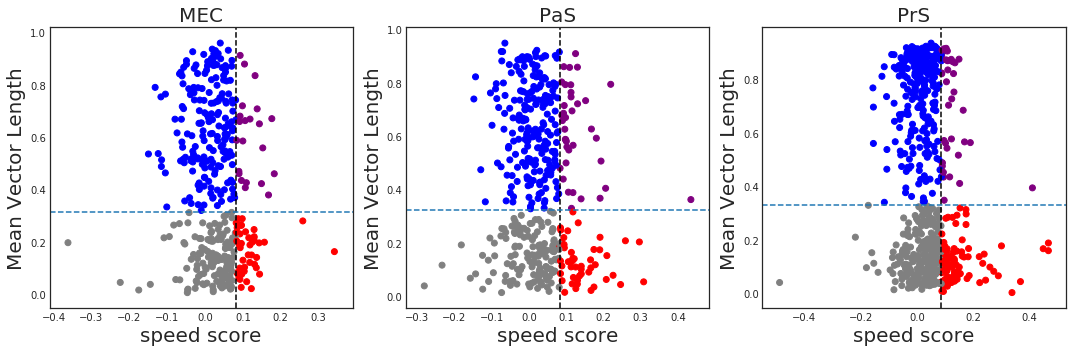

In [126]:
#CORRELATION BETWEEN SPEED SCORE AND Mean Vector Length
figure(figsize=(15,5))
subplot(1,3,1)
cellMEC=cellMetadata[cellMetadata["region"]=="MEC"]
x=cellMEC["speedScore"].values
y=cellMEC["meanVecLen"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=MECcolors)
axvline(x=cellMEC["speedTh"].values[0],linestyle='--',c='k')
axhline(y=MECth,linestyle='--')
xlabel("speed score",fontsize=20)
ylabel("Mean Vector Length",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("MEC",fontsize=20)
print("MEC:"+str(pearsonr(a,b)))
subplot(1,3,2)
cellPaS=cellMetadata[cellMetadata["region"]=="PaS"]
x=cellPaS["speedScore"].values
y=cellPaS["meanVecLen"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=PaScolors)
axvline(x=cellPaS["speedTh"].values[0],linestyle='--',c='k')
axhline(y=PaSth,linestyle='--')
xlabel("speed score",fontsize=20)
ylabel("Mean Vector Length",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("PaS",fontsize=20)
print("PaS:"+str(pearsonr(a,b)))
subplot(1,3,3)
cellPrS=cellMetadata[cellMetadata["region"]=="PrS"]
x=cellPrS["speedScore"].values
y=cellPrS["meanVecLen"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=PrScolors)
axvline(x=cellPrS["speedTh"].values[10],linestyle='--',c='k')
axhline(y=PrSth,linestyle='--')
xlabel("speed score",fontsize=20)
ylabel("Mean Vector Length",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("PrS",fontsize=20)
print("PrS:"+str(pearsonr(a,b)))
tight_layout()
savefig("imgs/svg/correlation_speed_HD.svg")

## HD - Angular velocity

In [127]:
tot_cellCW=len(cellMetadata[(cellMetadata["angularVelocityModulated"]==1)])
tot_modulatedCW=len(cellMetadata[(cellMetadata["angularVelocityModulated"]==1) &  (cellMetadata["HDmodulated"]==1)])
totMECCW=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC') & (cellMetadata["angularVelocityModulated"]==1)])
modMECCW=len(cellMetadata[(cellMetadata["angularVelocityModulated"]==1)  & (cellMetadata["region"]=='MEC') & (cellMetadata["HDmodulated"]==1)])
totPaSCW=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')& (cellMetadata["angularVelocityModulated"]==1)])
modPaSCW=len(cellMetadata[(cellMetadata["angularVelocityModulated"]==1)  & (cellMetadata["region"]=='PaS')& (cellMetadata["HDmodulated"]==1)])
totPrSCW=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')& (cellMetadata["angularVelocityModulated"]==1)])
modPrSCW=len(cellMetadata[(cellMetadata["angularVelocityModulated"]==1)  & (cellMetadata["region"]=='PrS')& (cellMetadata["HDmodulated"]==1)])

print("HD modulated angular velocity CW cells in all regions: "+str(tot_modulatedCW)+"/"+str(tot_cellCW)+ " ("+str(tot_modulatedCW/tot_cellCW)+")")
print("HD modulated angular velocity CW in MEC: "+str(modMECCW)+"/"+str(totMECCW)+ " ("+str(modMECCW/totMECCW)+")")
print("HD modulated angular velocity CW cells in PaS: "+str(modPaSCW)+"/"+str(totPaSCW)+ " ("+str(modPaSCW/totPaSCW)+")")
print("HD modulated angular velocity CW cells in PrS: "+str(modPrSCW)+"/"+str(totPrSCW)+ " ("+str(modPrSCW/totPrSCW)+")")

HD modulated angular velocity CW cells in all regions: 39/69 (0.5652173913043478)
HD modulated angular velocity CW in MEC: 13/18 (0.7222222222222222)
HD modulated angular velocity CW cells in PaS: 17/24 (0.7083333333333334)
HD modulated angular velocity CW cells in PrS: 9/27 (0.3333333333333333)


In [128]:
#Percentage of angular Acceleration modulated cells:
tot_cellCCW=len(cellMetadata[(cellMetadata["angularVelocityCCWModulated"]==1)])
tot_modulatedCCW=len(cellMetadata[(cellMetadata["angularVelocityCCWModulated"]==1) &  (cellMetadata["HDmodulated"]==1)])
totMECCCW=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC') & (cellMetadata["angularVelocityCCWModulated"]==1)])
modMECCCW=len(cellMetadata[(cellMetadata["angularVelocityCCWModulated"]==1)  & (cellMetadata["region"]=='MEC') & (cellMetadata["HDmodulated"]==1)])
totPaSCCW=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')& (cellMetadata["angularVelocityCCWModulated"]==1)])
modPaSCCW=len(cellMetadata[(cellMetadata["angularVelocityCCWModulated"]==1)  & (cellMetadata["region"]=='PaS')& (cellMetadata["HDmodulated"]==1)])
totPrSCCW=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')& (cellMetadata["angularVelocityCCWModulated"]==1)])
modPrSCCW=len(cellMetadata[(cellMetadata["angularVelocityCCWModulated"]==1)  & (cellMetadata["region"]=='PrS')& (cellMetadata["HDmodulated"]==1)])

print("HD modulated angular velocity CCW cells in all regions: "+str(tot_modulatedCCW)+"/"+str(tot_cellCCW)+ " ("+str(tot_modulatedCCW/tot_cellCCW)+")")
print("HD modulated angular velocity CCW in MEC: "+str(modMECCCW)+"/"+str(totMECCCW)+ " ("+str(modMECCCW/totMECCCW)+")")
print("HD modulated angular velocity CCW cells in PaS: "+str(modPaSCCW)+"/"+str(totPaSCCW)+ " ("+str(modPaSCCW/totPaSCCW)+")")
print("HD modulated angular velocity CCW cells in PrS: "+str(modPrSCCW)+"/"+str(totPrSCCW)+ " ("+str(modPrSCCW/totPrSCCW)+")")

HD modulated angular velocity CCW cells in all regions: 34/68 (0.5)
HD modulated angular velocity CCW in MEC: 9/21 (0.42857142857142855)
HD modulated angular velocity CCW cells in PaS: 9/23 (0.391304347826087)
HD modulated angular velocity CCW cells in PrS: 16/24 (0.6666666666666666)


In [129]:
print("HD modulated angular velocity cells in all regions: "+str(tot_modulatedCCW+tot_modulatedCW)+"/"+str(tot_cellCCW+tot_cellCW)+ " ("+str((tot_modulatedCCW+tot_modulatedCW)/(tot_cellCCW+tot_cellCW))+")")
print("HD modulated angular velocity in MEC: "+str(modMECCCW+modMECCW)+"/"+str(totMECCCW+totMECCW)+ " ("+str((modMECCCW+modMECCW)/(totMECCCW+totMECCW))+")")
print("HD modulated angular velocity cells in PaS: "+str(modPaSCCW+modPaSCW)+"/"+str(totPaSCCW+totPaSCW)+ " ("+str((modPaSCCW+modPaSCW)/(totPaSCCW+totPaSCW))+")")
print("HD modulated angular velocity cells in PrS: "+str(modPrSCCW+modPrSCW)+"/"+str(totPrSCCW+totPrSCW)+ " ("+str((modPrSCCW+modPrSCW)/(totPrSCCW+totPrSCW))+")")

HD modulated angular velocity cells in all regions: 73/137 (0.5328467153284672)
HD modulated angular velocity in MEC: 22/39 (0.5641025641025641)
HD modulated angular velocity cells in PaS: 26/47 (0.5531914893617021)
HD modulated angular velocity cells in PrS: 25/51 (0.49019607843137253)


In [130]:
MECcolors=[]
MECcells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC')]
for i in MECcells.index:
    cell=MECcells.loc[i]
    if cell["HDmodulated"]==0 and cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0:
        MECcolors.append("grey")
    if cell["HDmodulated"]==1 and cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0:
        MECcolors.append("red")
    if cell["HDmodulated"]==0 and (cell["angularVelocityModulated"]==1 or cell["angularVelocityCCWModulated"]==1):
        MECcolors.append("blue")
    if cell["HDmodulated"]==1 and (cell["angularVelocityModulated"]==1 or cell["angularVelocityCCWModulated"]==1):
        MECcolors.append("purple")
######################
PaScolors=[]
PaScells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')]
for i in PaScells.index:
    cell=PaScells.loc[i]
    if cell["HDmodulated"]==0 and cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0:
        PaScolors.append("grey")
    if cell["HDmodulated"]==1 and cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0:
        PaScolors.append("red")
    if cell["HDmodulated"]==0 and (cell["angularVelocityModulated"]==1 or cell["angularVelocityCCWModulated"]==1):
        PaScolors.append("blue")
    if cell["HDmodulated"]==1 and (cell["angularVelocityModulated"]==1 or cell["angularVelocityCCWModulated"]==1):
        PaScolors.append("purple")
######################
PrScolors=[]
PrScells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')]
for i in PrScells.index:
    cell=PrScells.loc[i]
    if cell["HDmodulated"]==0 and cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0:
        PrScolors.append("grey")
    if cell["HDmodulated"]==1 and cell["angularVelocityModulated"]==0 and cell["angularVelocityCCWModulated"]==0:
        PrScolors.append("red")
    if cell["HDmodulated"]==0 and (cell["angularVelocityModulated"]==1 or cell["angularVelocityCCWModulated"]==1):
        PrScolors.append("blue")
    if cell["HDmodulated"]==1 and (cell["angularVelocityModulated"]==1 or cell["angularVelocityCCWModulated"]==1):
        PrScolors.append("purple")

MEC:(0.09187416024174636, 0.06779641456563563)
PaS:(0.1205328250688616, 0.01187435492412)
PrS:(-0.07715045470632151, 0.057886926437294275)


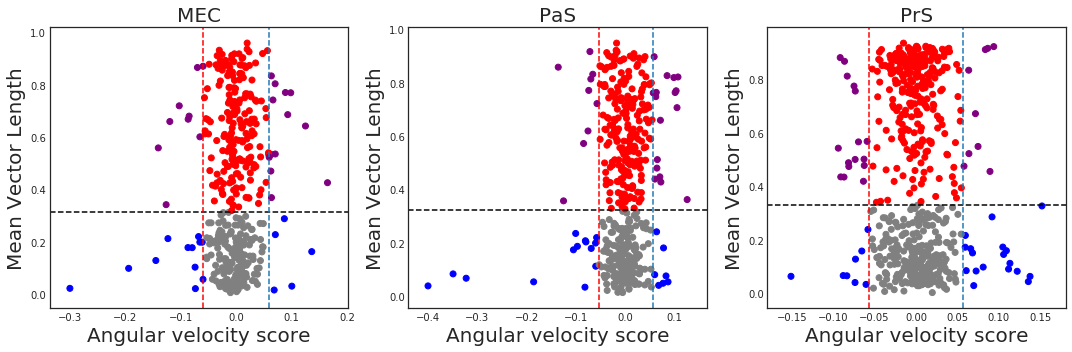

In [131]:
#CORRELATION BETWEEN Mean Vector Length AND Mean Vector Length
figure(figsize=(15,5))
subplot(1,3,1)
cellMEC=cellMetadata[cellMetadata["region"]=="MEC"]
y=cellMEC["meanVecLen"].values
x=cellMEC["angularVelocityScore"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=MECcolors)
axhline(y=MECth,linestyle='--',c='k')
axvline(x=cellMEC["angularVelocityTh"].values[0],linestyle='--')
axvline(x=cellMEC["angularVelocityCCWTh"].values[0],linestyle='--',c='r')
ylabel("Mean Vector Length",fontsize=20)
xlabel("Angular velocity score",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("MEC",fontsize=20)
print("MEC:"+str(pearsonr(a,b)))
subplot(1,3,2)
cellPaS=cellMetadata[cellMetadata["region"]=="PaS"]
y=cellPaS["meanVecLen"].values
x=cellPaS["angularVelocityScore"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=PaScolors)
axhline(y=PaSth,linestyle='--',c='k')
axvline(x=cellPaS["angularVelocityTh"].values[0],linestyle='--')
axvline(x=cellPaS["angularVelocityCCWTh"].values[0],linestyle='--',c='r')
ylabel("Mean Vector Length",fontsize=20)
xlabel("Angular velocity score",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("PaS",fontsize=20)
print("PaS:"+str(pearsonr(a,b)))
subplot(1,3,3)
cellPrS=cellMetadata[cellMetadata["region"]=="PrS"]
y=cellPrS["meanVecLen"].values
x=cellPrS["angularVelocityScore"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=PrScolors)
axhline(y=PrSth,linestyle='--',c='k')
axvline(x=cellPrS["angularVelocityTh"].values[10],linestyle='--')
axvline(x=cellPrS["angularVelocityCCWTh"].values[10],linestyle='--',c='r')
ylabel("Mean Vector Length",fontsize=20)
xlabel("Angular velocity score",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("PrS",fontsize=20)
print("PrS:"+str(pearsonr(a,b)))
tight_layout()
savefig("imgs/svg/correlation_angulavelocity_HD.svg")

## HD - Acceleration

In [132]:
#Percentage of angular Acceleration modulated cells:
tot_cell=len(cellMetadata[(cellMetadata["accelerationModulated"]==1)])
tot_modulated=len(cellMetadata[(cellMetadata["accelerationModulated"]==1) & (cellMetadata["HDmodulated"]==1)])
totMEC=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC') & (cellMetadata["accelerationModulated"]==1)])
modMEC=len(cellMetadata[(cellMetadata["accelerationModulated"]==1) & (cellMetadata["region"]=='MEC') & (cellMetadata["HDmodulated"]==1)])
totPaS=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')& (cellMetadata["accelerationModulated"]==1)])
modPaS=len(cellMetadata[(cellMetadata["accelerationModulated"]==1) & (cellMetadata["region"]=='PaS')& (cellMetadata["HDmodulated"]==1)])
totPrS=len(cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')& (cellMetadata["accelerationModulated"]==1)])
modPrS=len(cellMetadata[(cellMetadata["accelerationModulated"]==1) & (cellMetadata["region"]=='PrS')& (cellMetadata["HDmodulated"]==1)])

print("HD modulated acceleration cells in all regions: "+str(tot_modulated)+"/"+str(tot_cell)+ " ("+str(tot_modulated/tot_cell)+")")
print("HD modulated acceleration cells in MEC: "+str(modMEC)+"/"+str(totMEC)+ " ("+str(modMEC/totMEC)+")")
print("HD modulated acceleration cells in PaS: "+str(modPaS)+"/"+str(totPaS)+ " ("+str(modPaS/totPaS)+")")
print("HD modulated acceleration cells in PrS: "+str(modPrS)+"/"+str(totPrS)+ " ("+str(modPrS/totPrS)+")")

HD modulated acceleration cells in all regions: 84/155 (0.5419354838709678)
HD modulated acceleration cells in MEC: 30/44 (0.6818181818181818)
HD modulated acceleration cells in PaS: 33/47 (0.7021276595744681)
HD modulated acceleration cells in PrS: 21/64 (0.328125)


In [133]:
MECcolors=[]
MECcells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='MEC')]
for i in MECcells.index:
    cell=MECcells.loc[i]
    if cell["accelerationModulated"]==0 and cell["HDmodulated"]==0 :
        MECcolors.append("grey")
    if cell["accelerationModulated"]==1 and cell["HDmodulated"]==0:
        MECcolors.append("red")
    if cell["accelerationModulated"]==0 and cell["HDmodulated"]==1:
        MECcolors.append("blue")
    if cell["accelerationModulated"]==1 and cell["HDmodulated"]==1:
        MECcolors.append("purple")
######################
PaScolors=[]
PaScells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PaS')]
for i in PaScells.index:
    cell=PaScells.loc[i]
    if cell["accelerationModulated"]==0 and cell["HDmodulated"]==0:
        PaScolors.append("grey")
    if cell["accelerationModulated"]==1 and cell["HDmodulated"]==0:
        PaScolors.append("red")
    if cell["accelerationModulated"]==0 and cell["HDmodulated"]==1:
        PaScolors.append("blue")
    if cell["accelerationModulated"]==1 and cell["HDmodulated"]==1:
        PaScolors.append("purple")
######################
PrScolors=[]
PrScells=cellMetadata[(cellMetadata["include"]==1) & (cellMetadata["region"]=='PrS')]
for i in PrScells.index:
    cell=PrScells.loc[i]
    if cell["accelerationModulated"]==0 and cell["HDmodulated"]==0:
        PrScolors.append("grey")
    if cell["accelerationModulated"]==1 and cell["HDmodulated"]==0:
        PrScolors.append("red")
    if cell["accelerationModulated"]==0 and cell["HDmodulated"]==1:
        PrScolors.append("blue")
    if cell["accelerationModulated"]==1 and cell["HDmodulated"]==1:
        PrScolors.append("purple")

MEC:(0.04126967072533881, 0.41278131654552563)
PaS:(-0.0018361068789110014, 0.969540269480536)
PrS:(-0.15783604118258474, 9.671533114422985e-05)


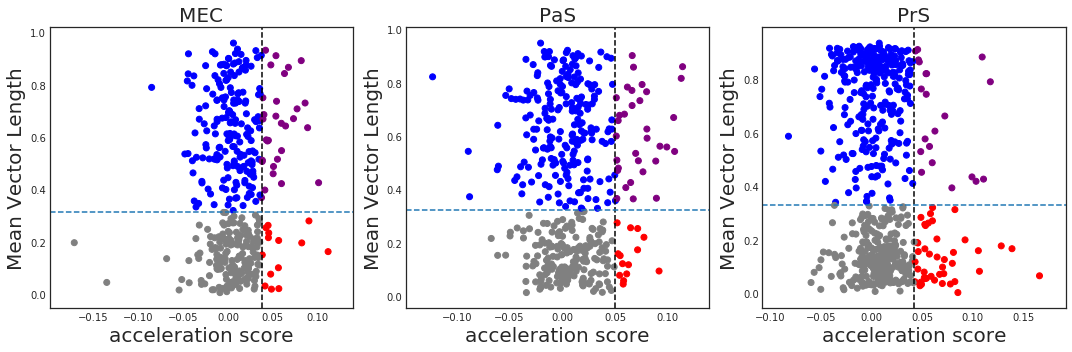

In [134]:
#CORRELATION BETWEEN acceleration SCORE AND Mean Vector Length
figure(figsize=(15,5))
subplot(1,3,1)
cellMEC=cellMetadata[cellMetadata["region"]=="MEC"]
x=cellMEC["accelerationScore"].values
y=cellMEC["meanVecLen"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=MECcolors)
axvline(x=cellMEC["accelerationTh"].values[0],linestyle='--',c='k')
axhline(y=MECth,linestyle='--')
xlabel("acceleration score",fontsize=20)
ylabel("Mean Vector Length",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("MEC",fontsize=20)
print("MEC:"+str(pearsonr(a,b)))
subplot(1,3,2)
cellPaS=cellMetadata[cellMetadata["region"]=="PaS"]
x=cellPaS["accelerationScore"].values
y=cellPaS["meanVecLen"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=PaScolors)
axvline(x=cellPaS["accelerationTh"].values[0],linestyle='--',c='k')
axhline(y=PaSth,linestyle='--')
xlabel("acceleration score",fontsize=20)
ylabel("Mean Vector Length",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("PaS",fontsize=20)
print("PaS:"+str(pearsonr(a,b)))
subplot(1,3,3)
cellPrS=cellMetadata[cellMetadata["region"]=="PrS"]
x=cellPrS["accelerationScore"].values
y=cellPrS["meanVecLen"].values
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
a=np.compress(bad, x)  
b=np.compress(bad, y) 
scatter(a,b,c=PrScolors)
axvline(x=cellPrS["accelerationTh"].values[10],linestyle='--',c='k')
axhline(y=PrSth,linestyle='--')
xlabel("acceleration score",fontsize=20)
ylabel("Mean Vector Length",fontsize=20)
#axis([-0.5,0.5,-0.45,0.2])
title("PrS",fontsize=20)
print("PrS:"+str(pearsonr(a,b)))
tight_layout()
savefig("imgs/svg/correlation_acceleration_HD.svg")

# FIGURE GENERATOR

In [2]:
HD=pd.read_csv("TrialData/HD.csv")
angularVelocity=pd.read_csv("TrialData/filteredAngularVelocity.csv")
speed=pd.read_csv("TrialData/filteredSpeed.csv")

trialMetadata=pd.read_csv("TrialData/metadata.csv",index_col=0)
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)

rate=pd.read_csv("CellData/firingRate.csv")

angularVelocity.columns=trialMetadata["trialIndex"].values
speed.columns=trialMetadata["trialIndex"].values
HD.columns=trialMetadata["trialIndex"].values

In [12]:
def calculateHDtuning(hd,rate):
    x=hd
    y=rate
    nbins=30
    sigma=2
    bad = ~np.logical_or(np.isnan(x), np.isnan(y))
    a=np.compress(bad, x)  
    b=np.compress(bad, y) 
    rawtuning=stats.binned_statistic(a,b, statistic='mean', bins=nbins, range=[0,2*pi])[0]
    smoothedtuning=gaussian_filter(rawtuning,sigma,mode='wrap')
    smoothedtuning[-1]=smoothedtuning[0]
    theta=np.linspace(0,2*pi,nbins)
    return theta,smoothedtuning

def calculateOccupancy(hd):
    nbins=60
    sigma=1
    a=[x for x in hd if not isnan(x)]
    rawtuning=histogram(a, bins=nbins, range=[0,2*pi])[0]
    smoothedtuning=gaussian_filter(rawtuning,sigma,mode='wrap')
    smoothedtuning[-1]=smoothedtuning[0]
    theta=np.linspace(0,2*pi,nbins)
    return theta,smoothedtuning

## SPEED

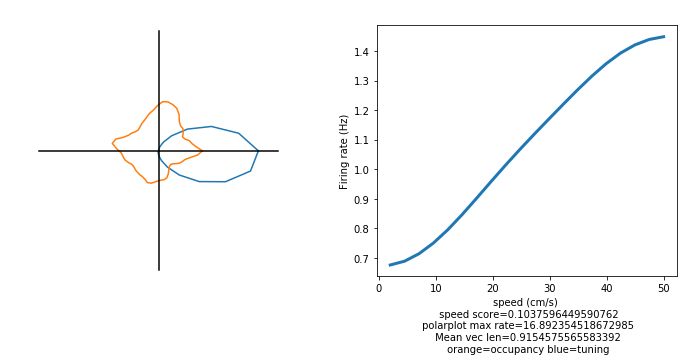

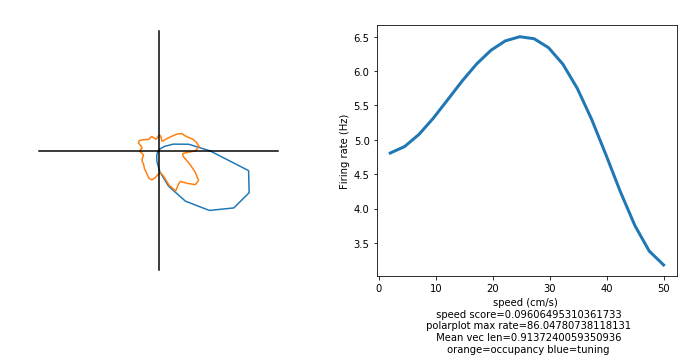

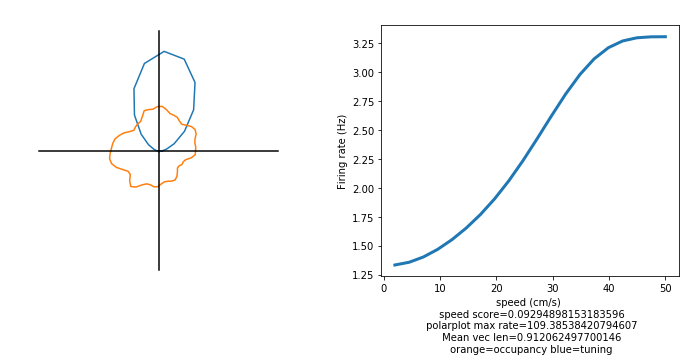

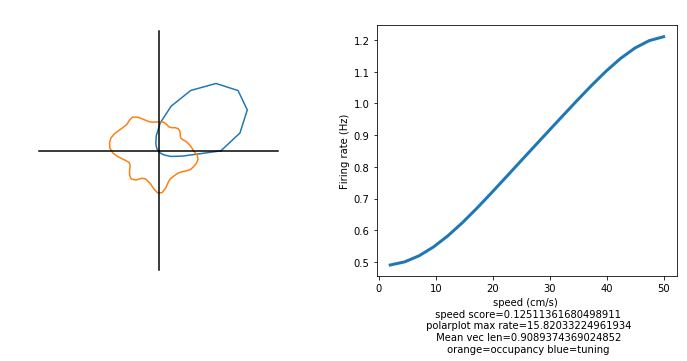

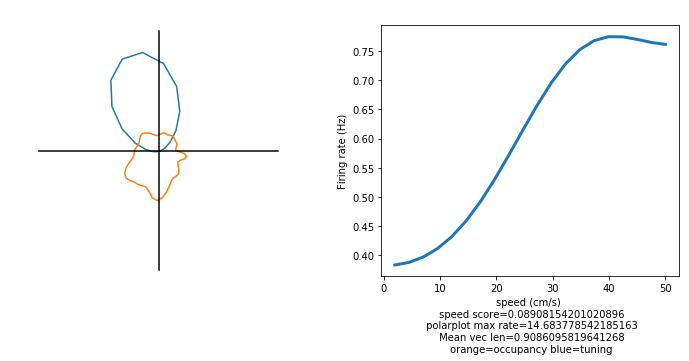

In [19]:
HDScoreSorted=cellMetadata[(cellMetadata["speedModulated"]==1)].sort_values("meanVecLen",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=speed[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(2,50,20)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[2,50])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("speed (cm/s) \n speed score="+str(HDScoreSorted["speedScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("HD_x_speed_cell"+str(cell+1)+".svg")

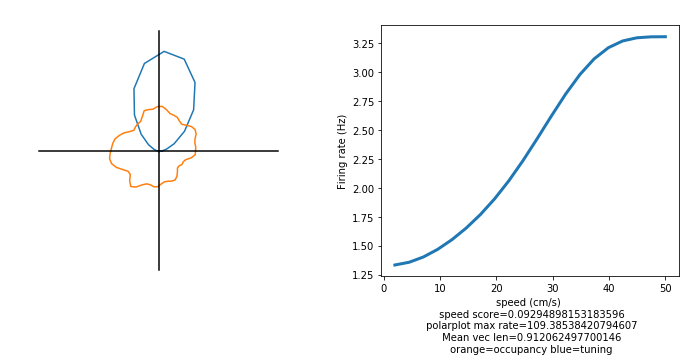

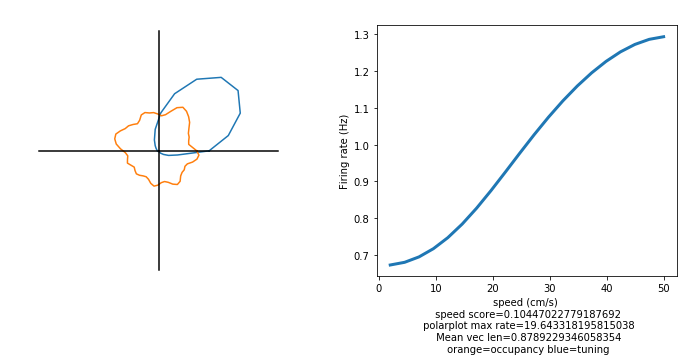

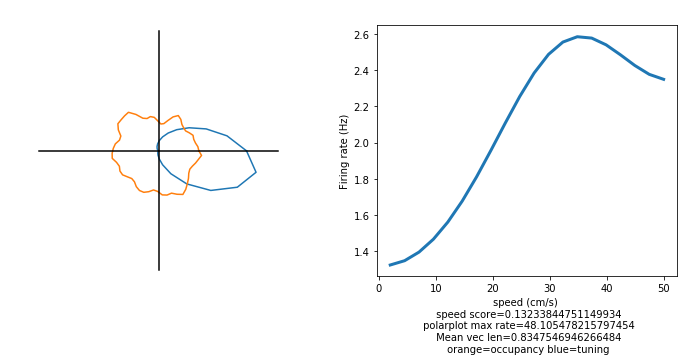

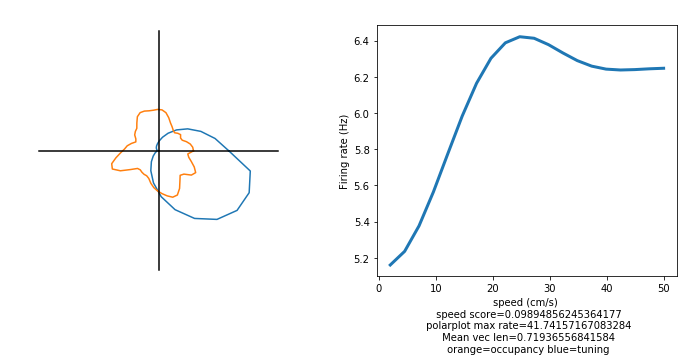

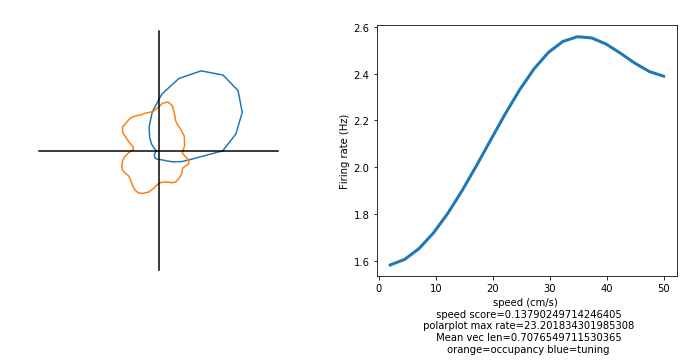

In [21]:
#BY REGION
MECcells=cellMetadata[cellMetadata["region"]=="MEC"]
HDScoreSorted=MECcells[(MECcells["speedModulated"]==1)].sort_values("meanVecLen",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=speed[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(2,50,20)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[2,50])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("speed (cm/s) \n speed score="+str(HDScoreSorted["speedScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("MEC_HD_x_speed_cell"+str(cell+1)+".svg")

## AV CW

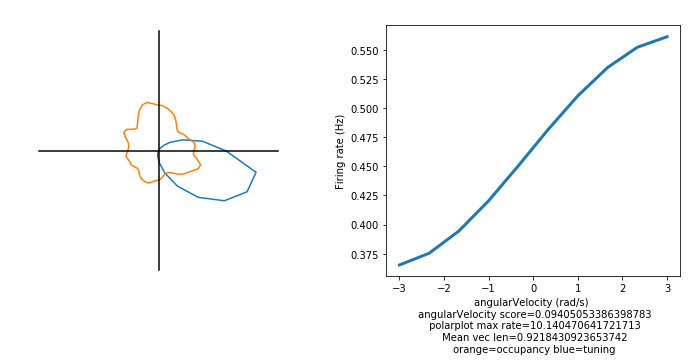

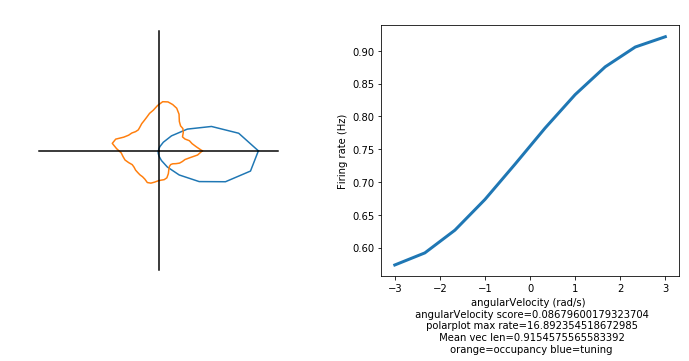

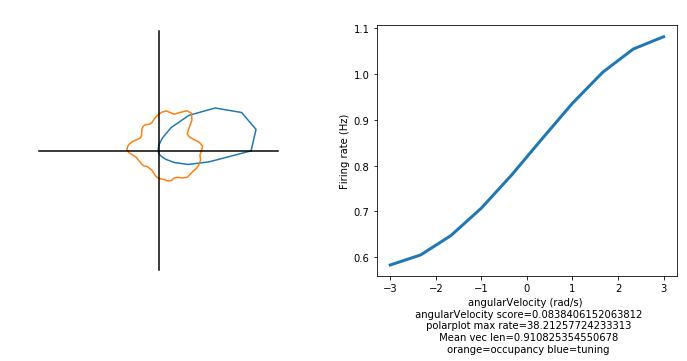

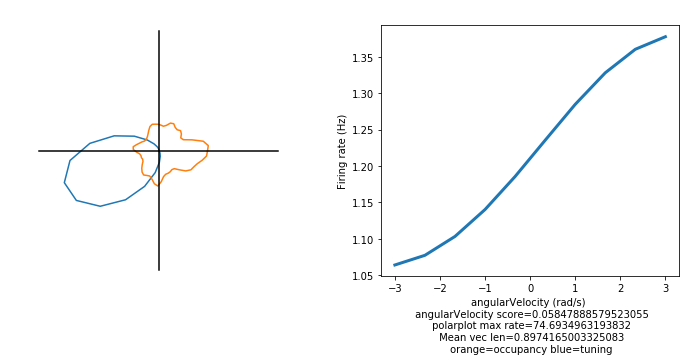

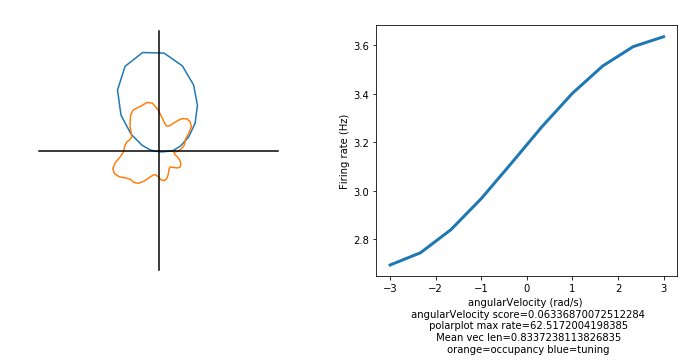

In [22]:
HDScoreSorted=cellMetadata[(cellMetadata["angularVelocityModulated"]==1)].sort_values("meanVecLen",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (rad/s) \n angularVelocity score="+str(HDScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("HD_x_angularVelocityCW_cell"+str(cell+1)+".svg")

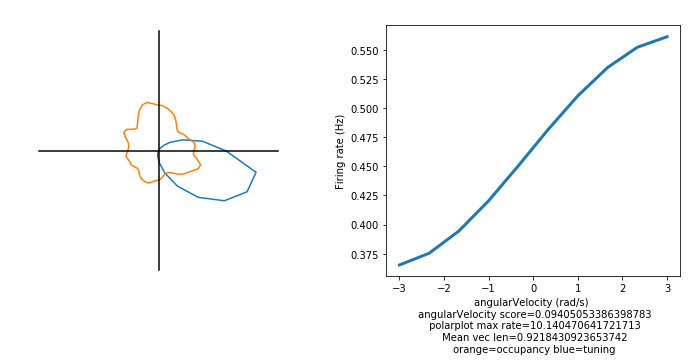

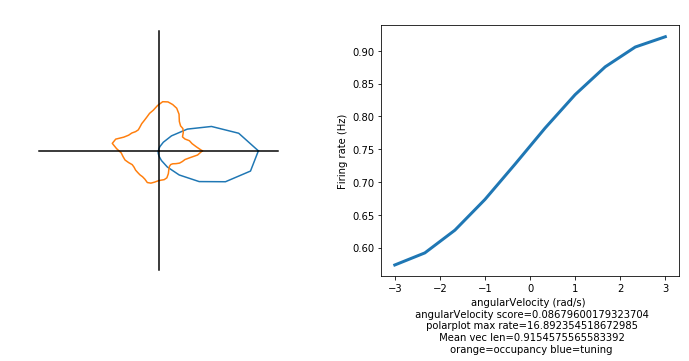

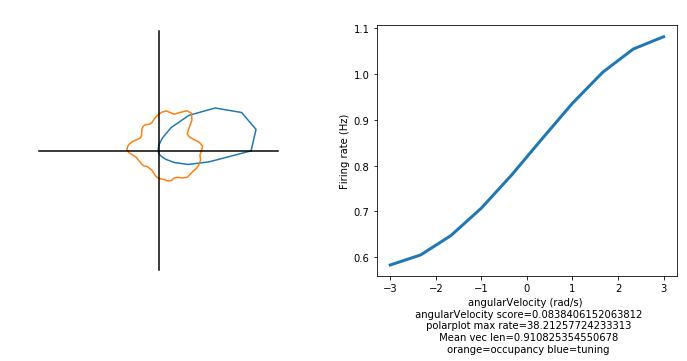

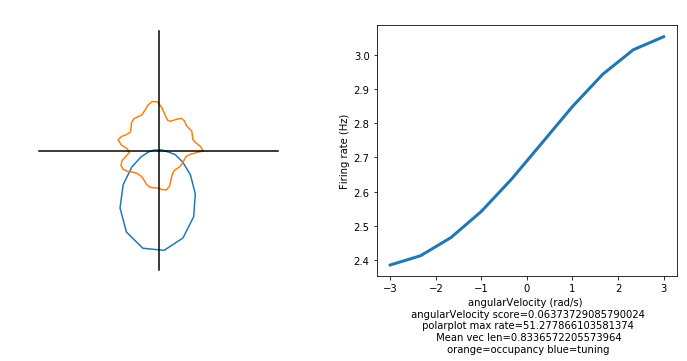

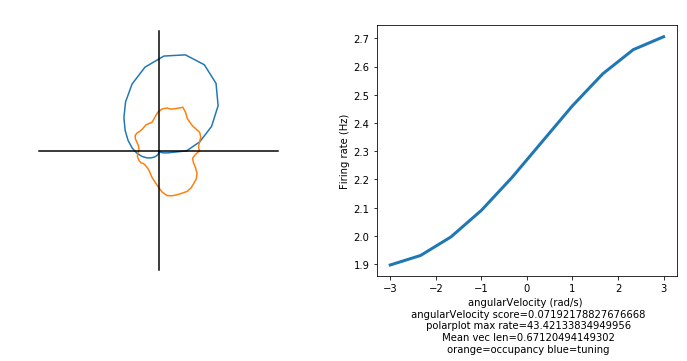

In [25]:
#BY REGION
PRScells=cellMetadata[cellMetadata["region"]=="PrS"]
HDScoreSorted=PRScells[(PRScells["angularVelocityModulated"]==1)].sort_values("meanVecLen",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (rad/s) \n angularVelocity score="+str(HDScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("PRS_HD_x_angularVelocityCW_cell"+str(cell+1)+".svg")

## AV CCW

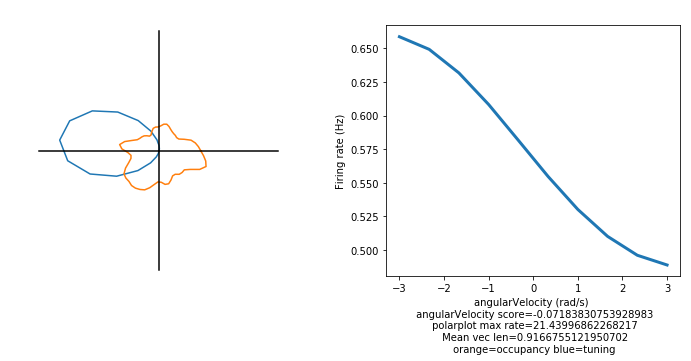

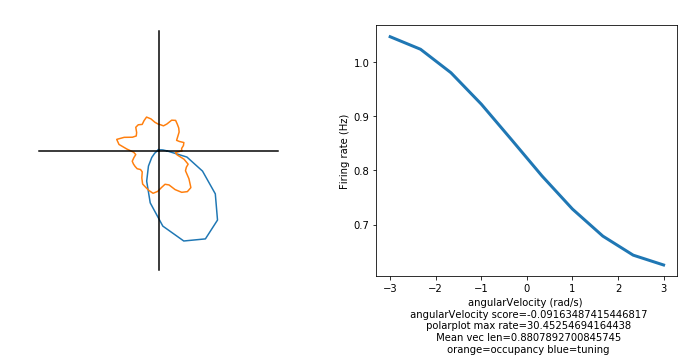

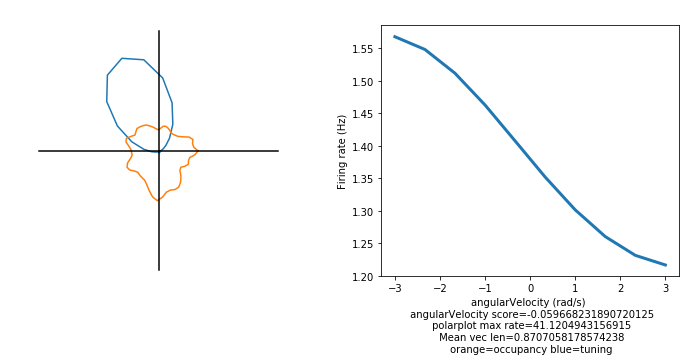

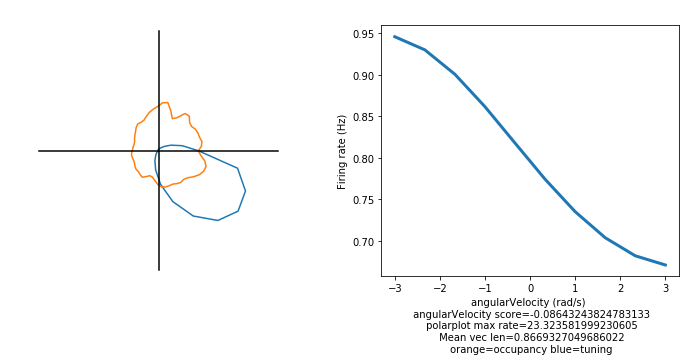

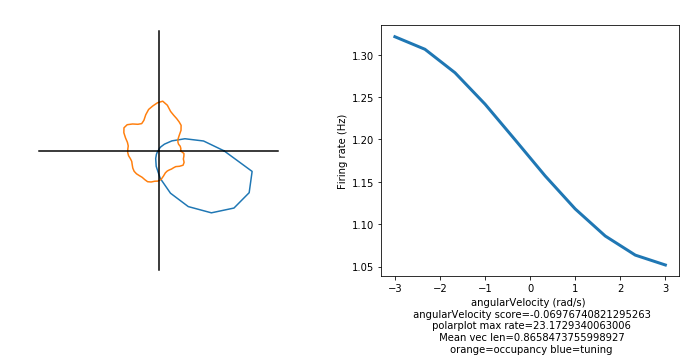

In [26]:
HDScoreSorted=cellMetadata[(cellMetadata["angularVelocityCCWModulated"]==1)].sort_values("meanVecLen",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (rad/s) \n angularVelocity score="+str(HDScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("HD_x_angularVelocityCCW_cell"+str(cell+1)+".svg")

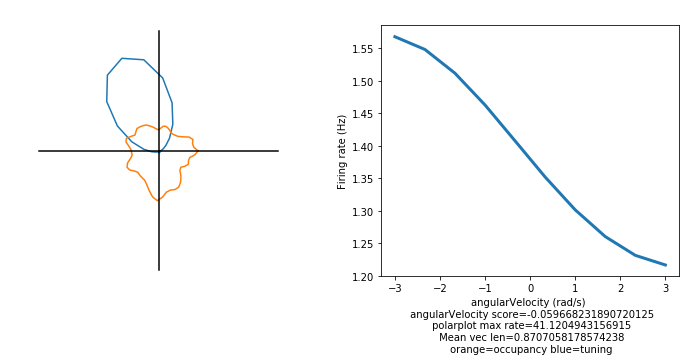

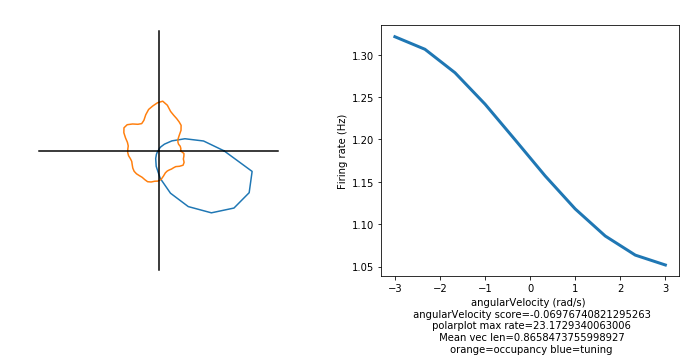

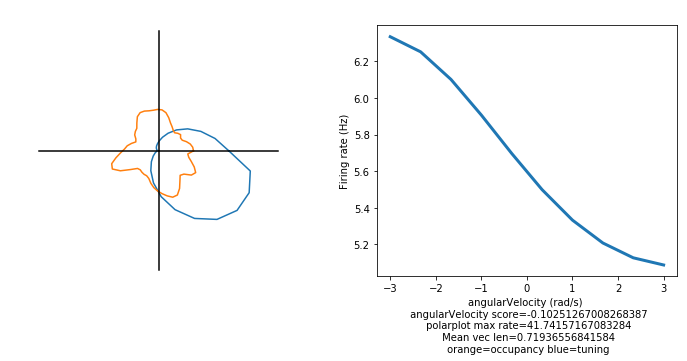

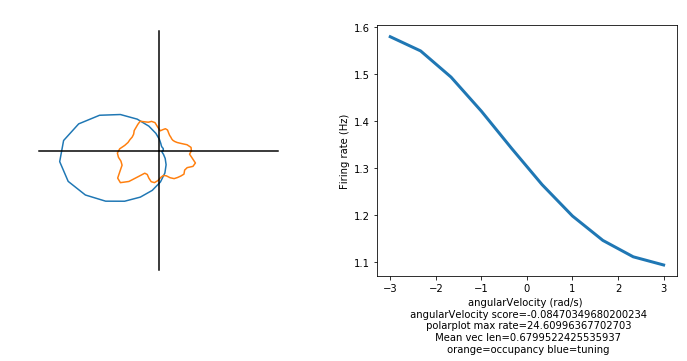

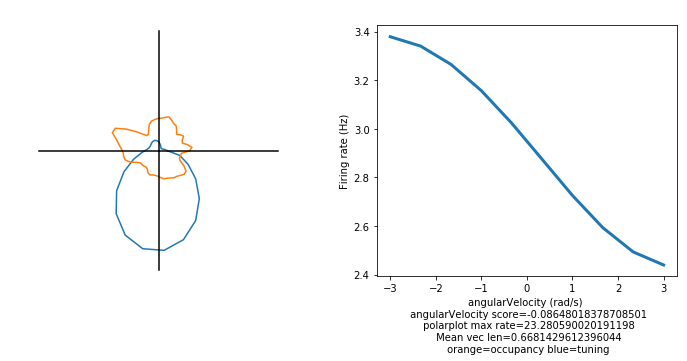

In [29]:
#BY REGION
MECcells=cellMetadata[cellMetadata["region"]=="MEC"]
HDScoreSorted=MECcells[(MECcells["angularVelocityCCWModulated"]==1)].sort_values("meanVecLen",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (rad/s) \n angularVelocity score="+str(HDScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("MEC_HD_x_angularVelocityCCW_cell"+str(cell+1)+".svg")

## AV ABS

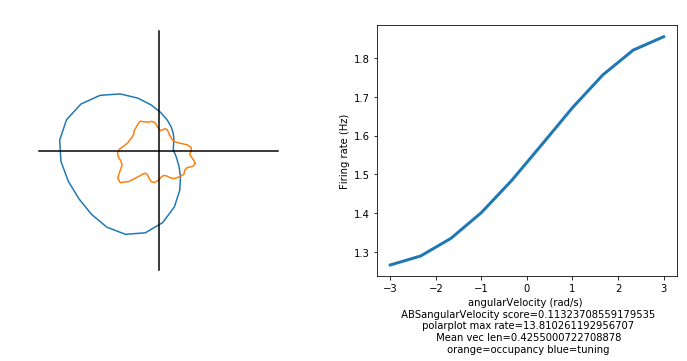

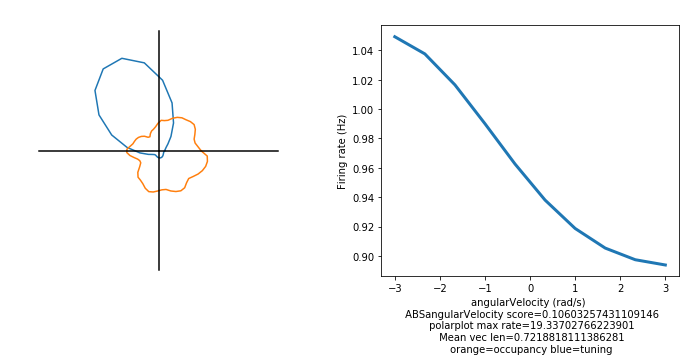

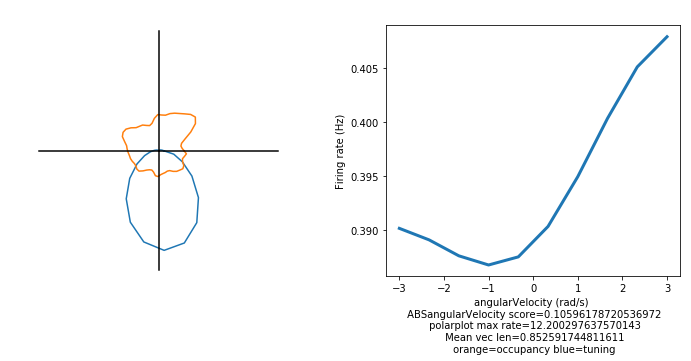

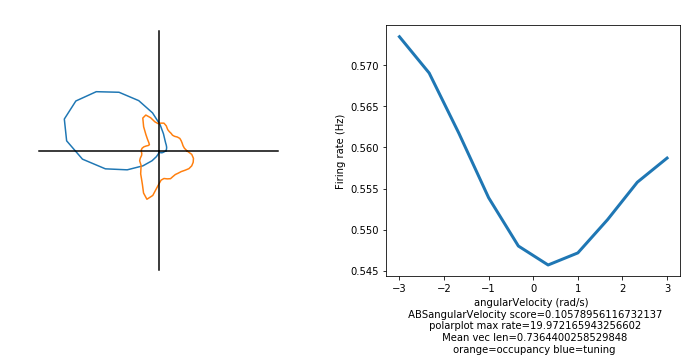

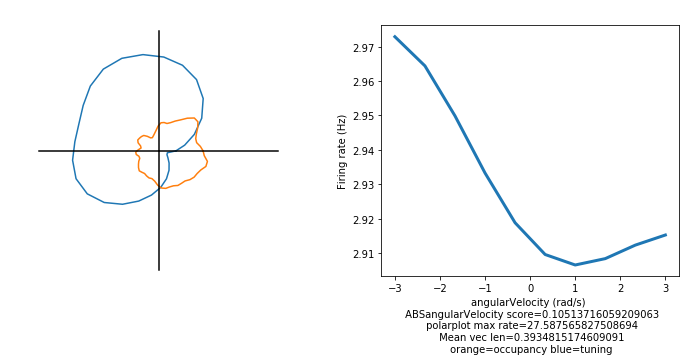

In [33]:
HDScoreSorted=cellMetadata[(cellMetadata["HDModulated"]==1)].sort_values("absAngularVelocityScore",ascending=False)

for cell in range(5,10):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (rad/s) \n ABSangularVelocity score="+str(HDScoreSorted["absAngularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("HD_x_ABSangularVelocity_cell"+str(cell+1)+".svg")

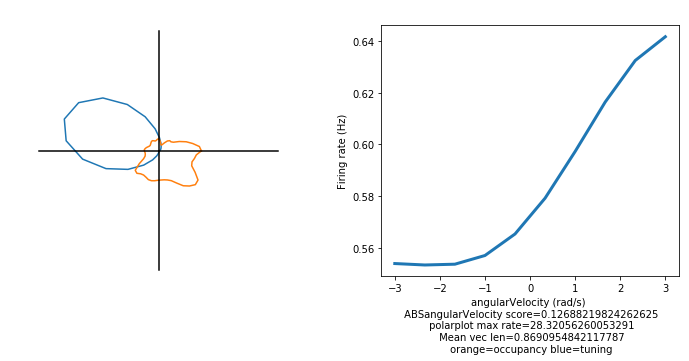

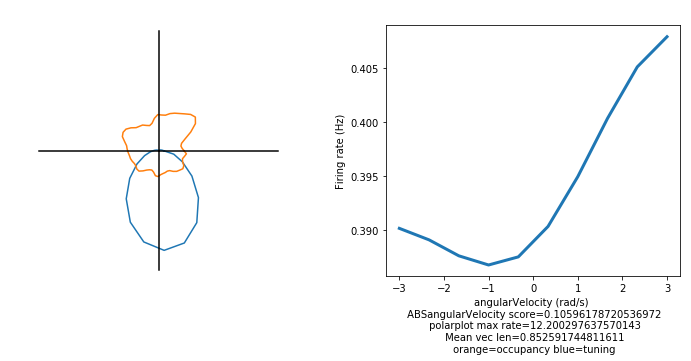

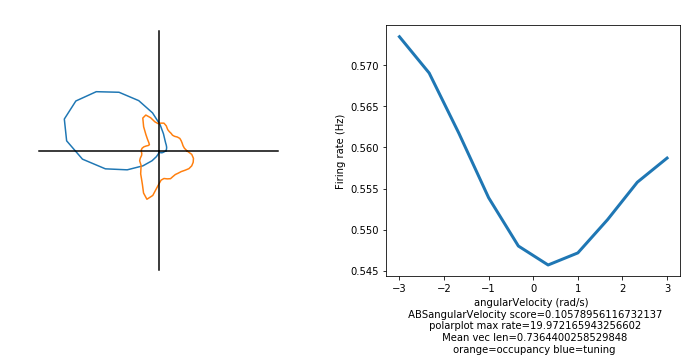

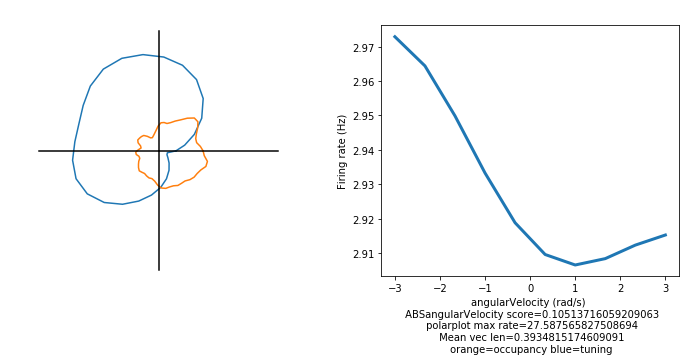

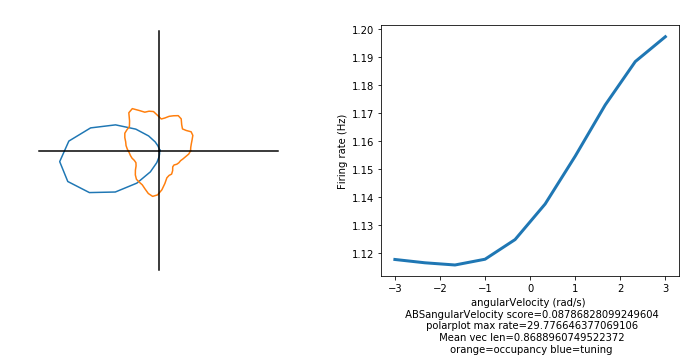

In [37]:
#BY REGION
PrScells=cellMetadata[cellMetadata["region"]=="PrS"]
HDScoreSorted=PrScells[(PrScells["HDModulated"]==1)].sort_values("absAngularVelocityScore",ascending=False)

for cell in range(5):
    r=rate[HDScoreSorted.index[cell]].values
    x=HD[HDScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[HDScoreSorted["trialIndex"][cell]].values
    figure(figsize=(10,5))
    ax=subplot(1,2,1, projection='polar')
    theta,tuning=calculateHDtuning(x,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(x)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #ax.text(1,-1.2*max(tuning),"max rate="+str(max(rate)))
    ax=subplot(1,2,2)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    #xlim((0,50))
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,4)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (rad/s) \n ABSangularVelocity score="+str(HDScoreSorted["absAngularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(HDScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("PrS_HD_x_ABSangularVelocityCCW_cell"+str(cell+1)+".svg")

# GRID X HD

In [53]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [54]:
%pylab inline
import scipy.ndimage.interpolation as rot
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats 
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap

Populating the interactive namespace from numpy and matplotlib


In [55]:
HD=pd.read_csv("TrialData/HD.csv")
angularVelocity=pd.read_csv("TrialData/filteredAngularVelocity.csv")
speed=pd.read_csv("TrialData/filteredSpeed.csv")
xs=pd.read_csv("TrialData/x1.csv")
ys=pd.read_csv("TrialData/y1.csv")

trialMetadata=pd.read_csv("TrialData/metadata.csv",index_col=0)
cellMetadata=pd.read_csv("CellData/metadata.csv",index_col=0)

rate=pd.read_csv("CellData/firingRate.csv")

angularVelocity.columns=trialMetadata["trialIndex"].values
speed.columns=trialMetadata["trialIndex"].values
HD.columns=trialMetadata["trialIndex"].values
xs.columns=trialMetadata["trialIndex"].values
ys.columns=trialMetadata["trialIndex"].values

In [56]:
def calculateHDtuning(hd,rate):
    x=hd
    y=rate
    nbins=30
    sigma=2
    bad = ~np.logical_or(np.isnan(x), np.isnan(y))
    a=np.compress(bad, x)  
    b=np.compress(bad, y) 
    rawtuning=stats.binned_statistic(a,b, statistic='mean', bins=nbins, range=[0,2*pi])[0]
    smoothedtuning=gaussian_filter(rawtuning,sigma,mode='wrap')
    smoothedtuning[-1]=smoothedtuning[0]
    theta=np.linspace(0,2*pi,nbins)
    return theta,smoothedtuning

def calculateOccupancy(hd):
    nbins=60
    sigma=1
    a=[x for x in hd if not isnan(x)]
    rawtuning=histogram(a, bins=nbins, range=[0,2*pi])[0]
    smoothedtuning=gaussian_filter(rawtuning,sigma,mode='wrap')
    smoothedtuning[-1]=smoothedtuning[0]
    theta=np.linspace(0,2*pi,nbins)
    return theta,smoothedtuning

def calculatePlotRatemap(x,y,rate,dim):
    binwidth=2 #2 cm bins
    xrange=dim
    yrange=dim
    nbinsx=int(xrange/binwidth)
    nbinsy=int(yrange/binwidth)
    sigma=2 #2 bins = 4 cms
    bad = ~np.logical_or(np.isnan(x), np.isnan(y))
    a=np.compress(bad, x)  
    b=np.compress(bad, y)
    c=compress(bad,rate)
    rawmap=stats.binned_statistic_2d(a,b,c, statistic='mean', bins=[nbinsx,nbinsy],range=None)[0]
    rawmap[np.isnan(rawmap)]=0
    smoothedmap=gaussian_filter(rawmap,sigma)
    return smoothedmap

def autocorrelation(rate_map, mode='full', normalize=True):
    return fftcorrelate2d(rate_map, rate_map, mode=mode, normalize=normalize)

def fftcorrelate2d(arr1, arr2, mode='full', normalize=True):
    from scipy.signal import fftconvolve
    if normalize:
        a_ = np.reshape(arr1, (1, arr1.size))
        v_ = np.reshape(arr2, (1, arr2.size))
        arr1 = (arr1 - np.mean(a_)) / (np.std(a_) * len(a_))
        arr2 = (arr2 - np.mean(v_)) / np.std(v_)
    corr = fftconvolve(arr1, np.fliplr(np.flipud(arr2)), mode=mode)
    return corr

## SPEED

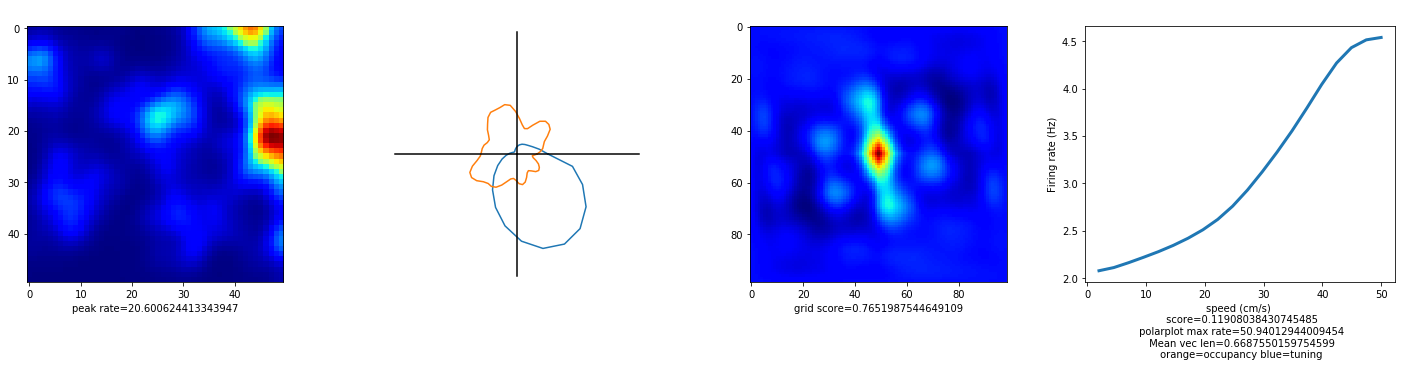

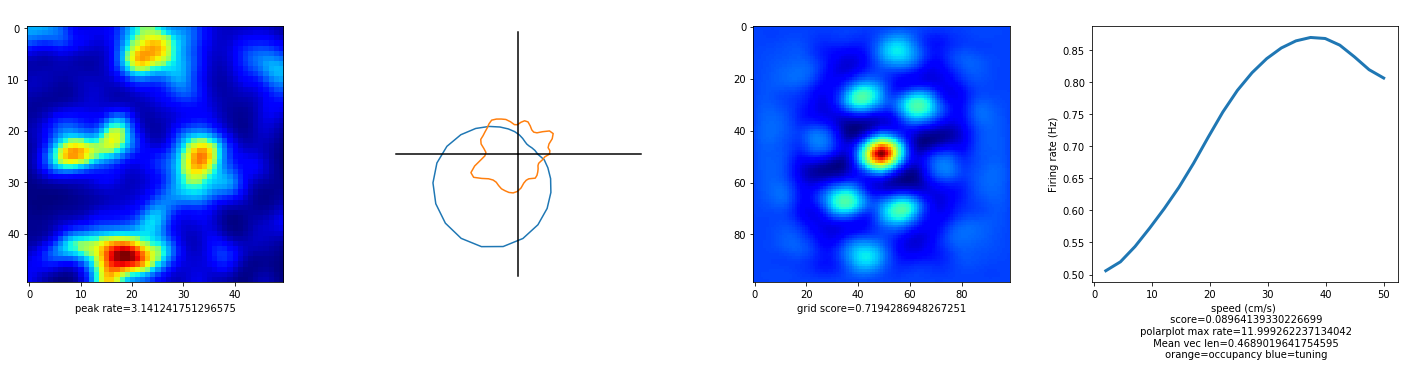

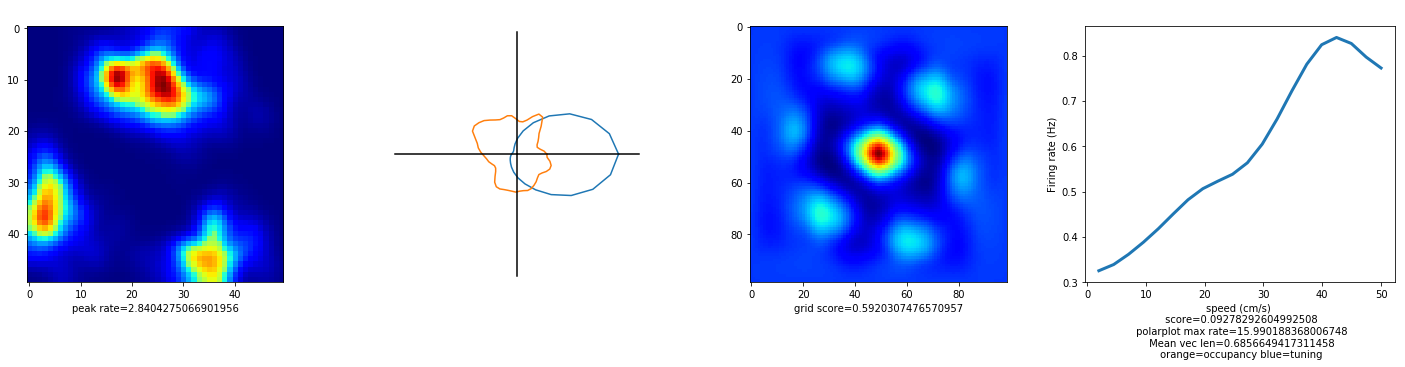

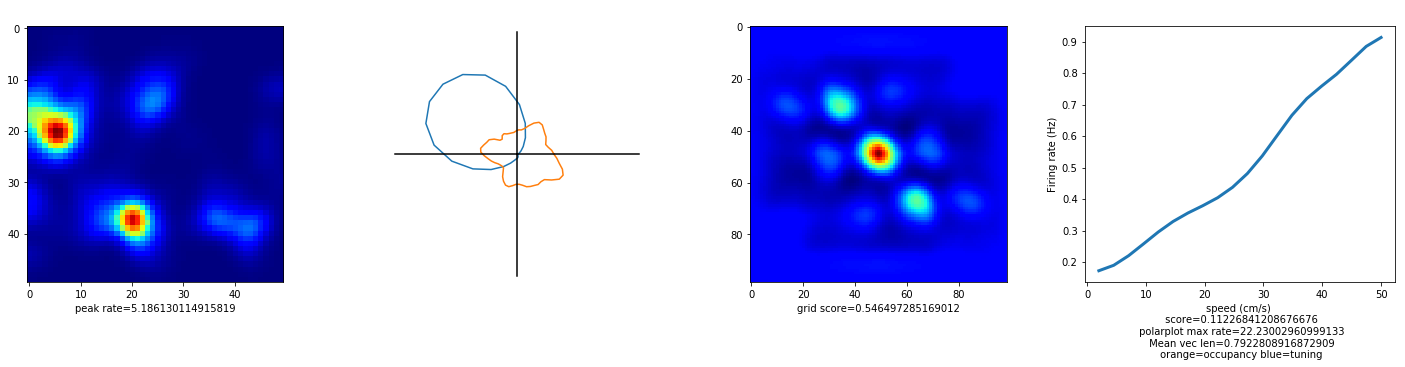

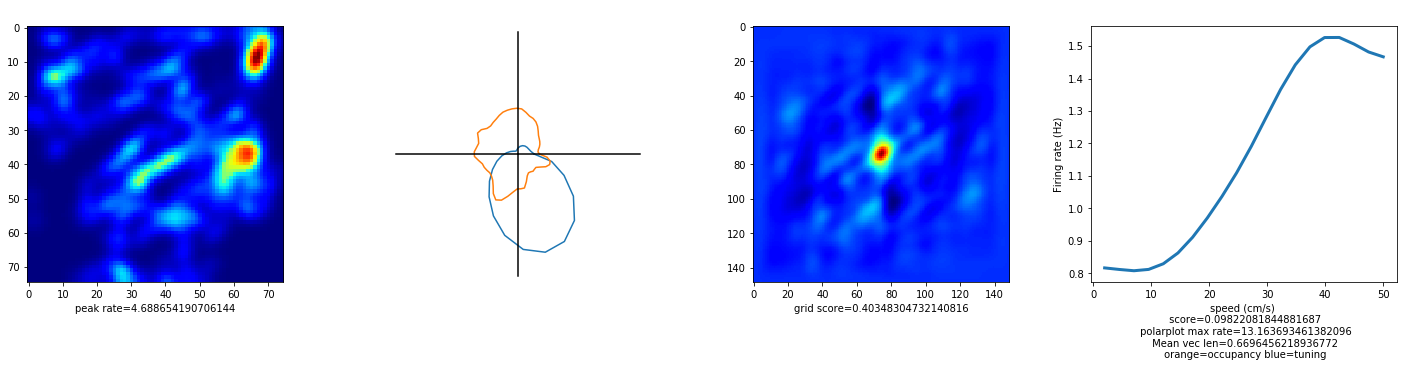

In [75]:
gridScoreSorted=cellMetadata[(cellMetadata["HDModulated"]==1)&(cellMetadata["speedModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    s=speed[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(2,50,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[2,50])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("speed (cm/s) \n score="+str(gridScoreSorted["speedScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("Grid_x_HD_speed_cell"+str(cell+1)+".svg")

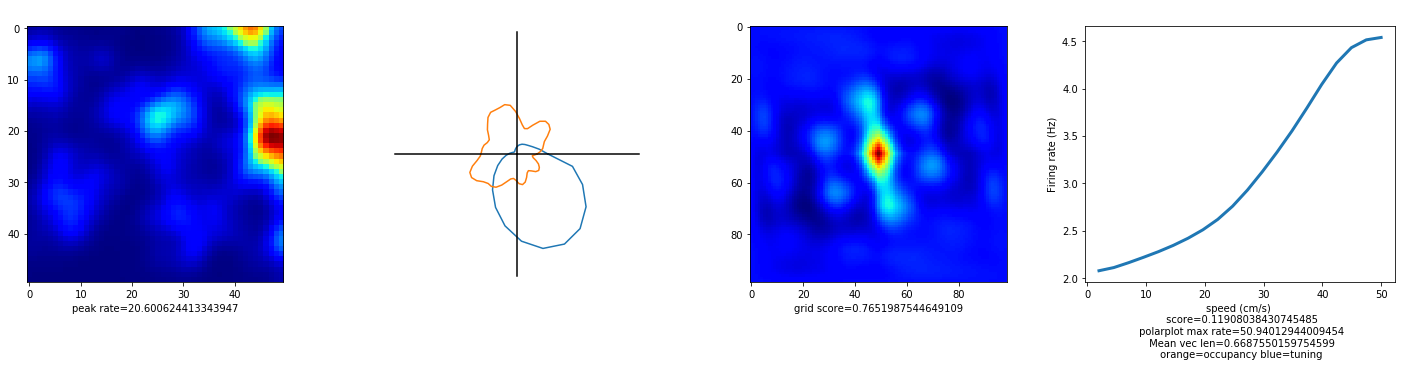

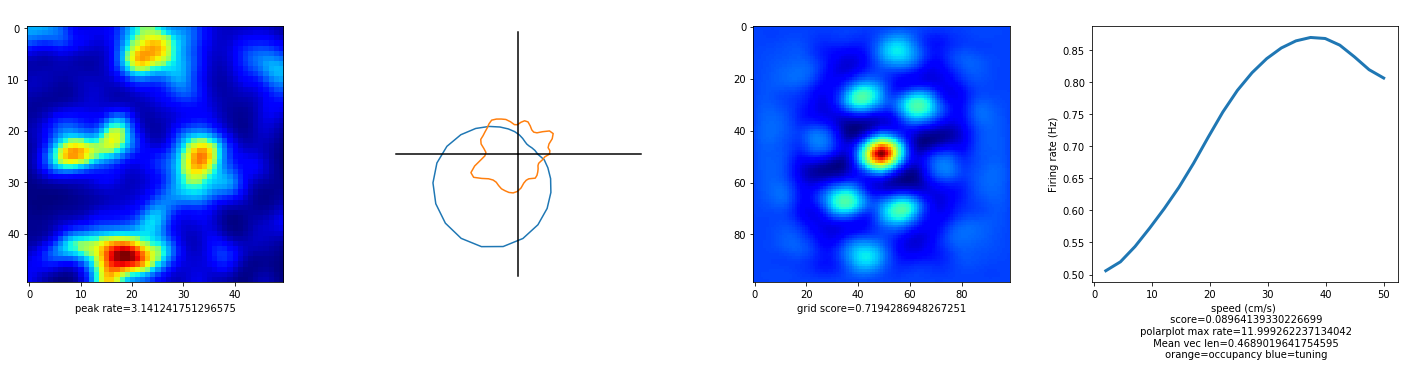

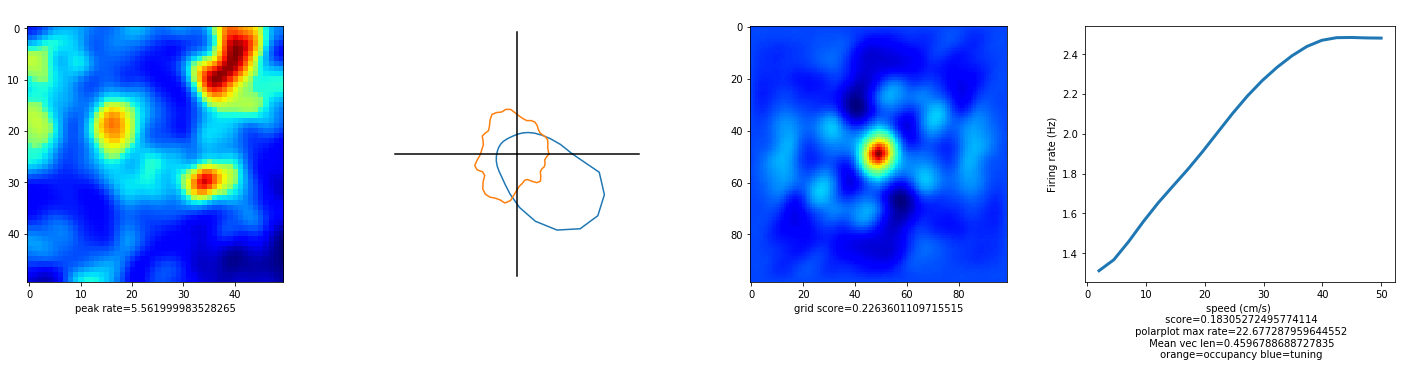

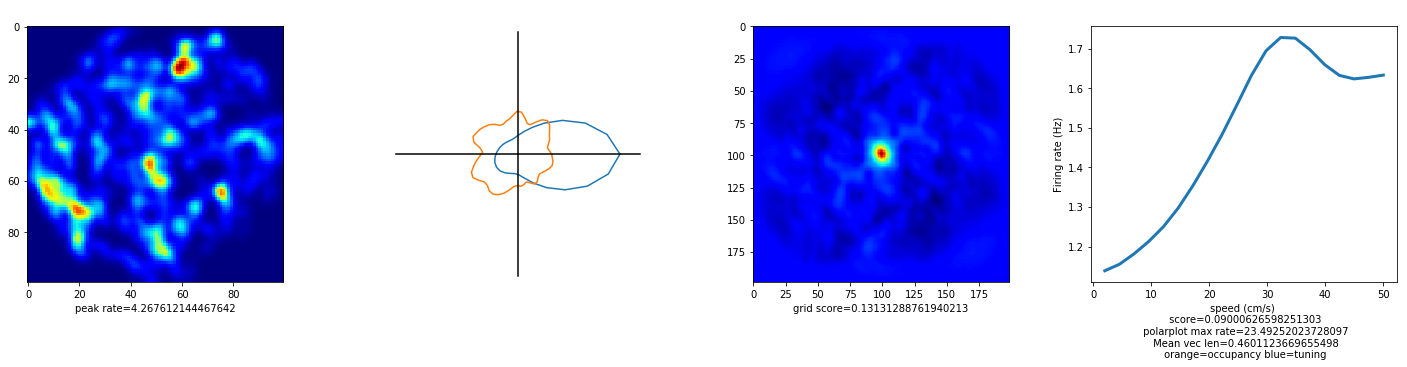

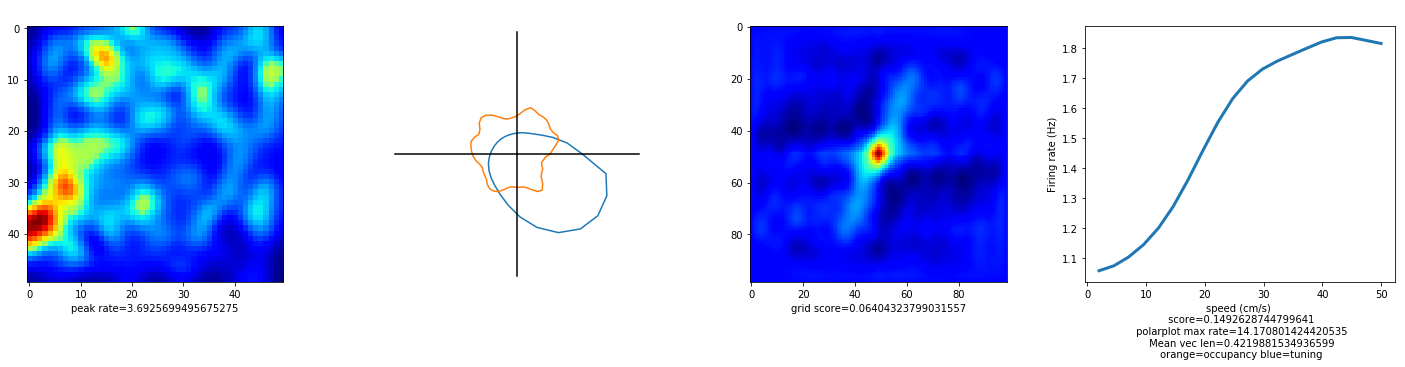

In [78]:
MECcells=cellMetadata[cellMetadata["region"]=="MEC"]
gridScoreSorted=MECcells[(MECcells["HDModulated"]==1)&(MECcells["speedModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=speed[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(2,50,20)
    y=stats.binned_statistic(a,b, statistic='mean', bins=20, range=[2,50])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("speed (cm/s) \n score="+str(gridScoreSorted["speedScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("MEC_Grid_x_HD_speed_cell"+str(cell+1)+".svg")

## CW AV

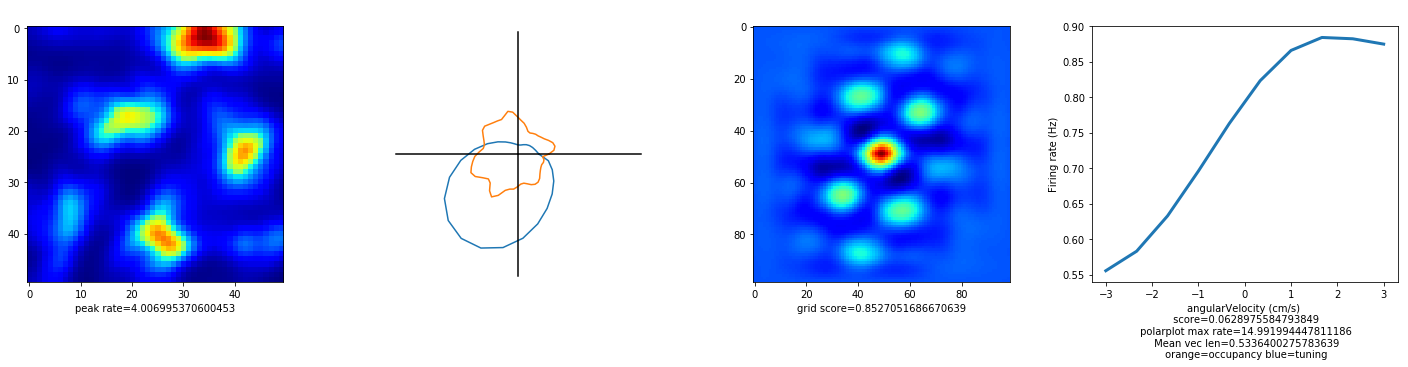

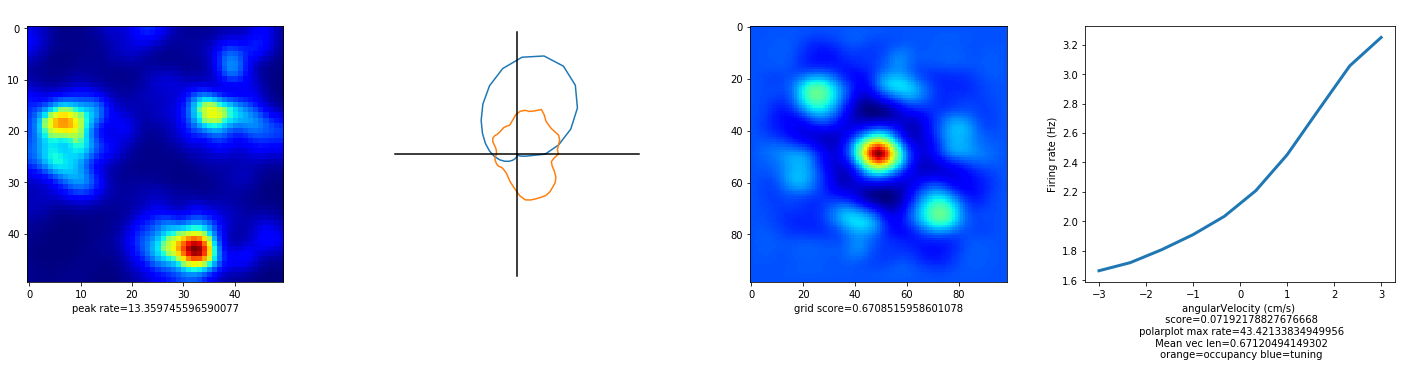

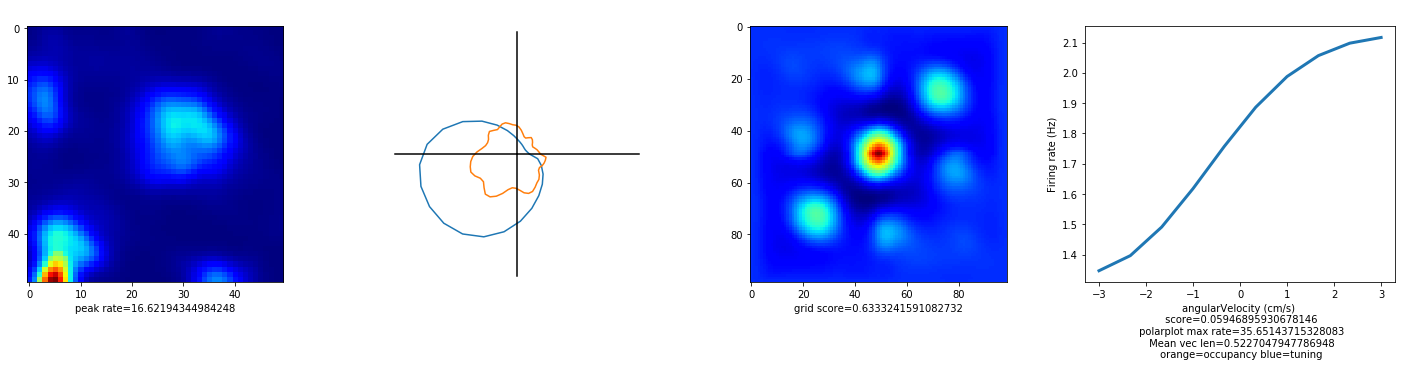

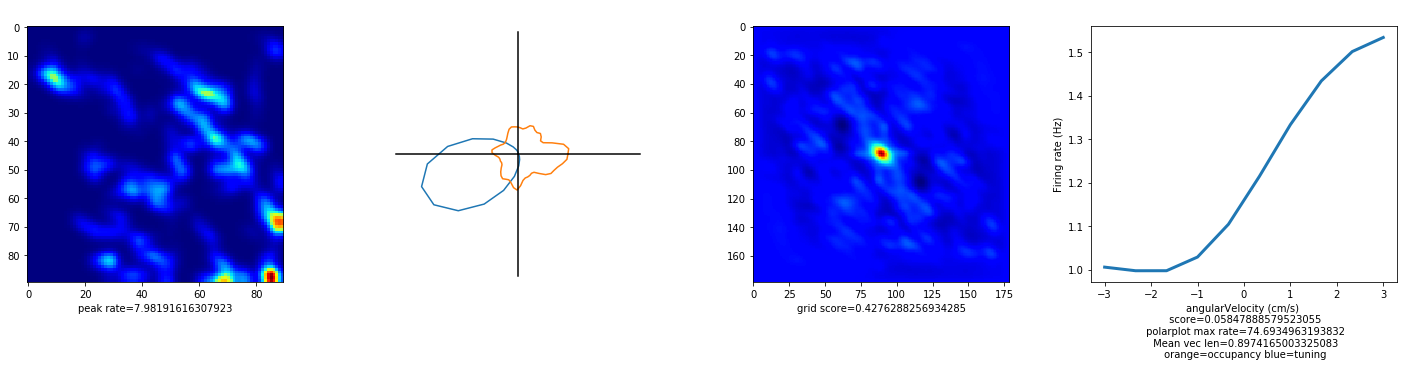

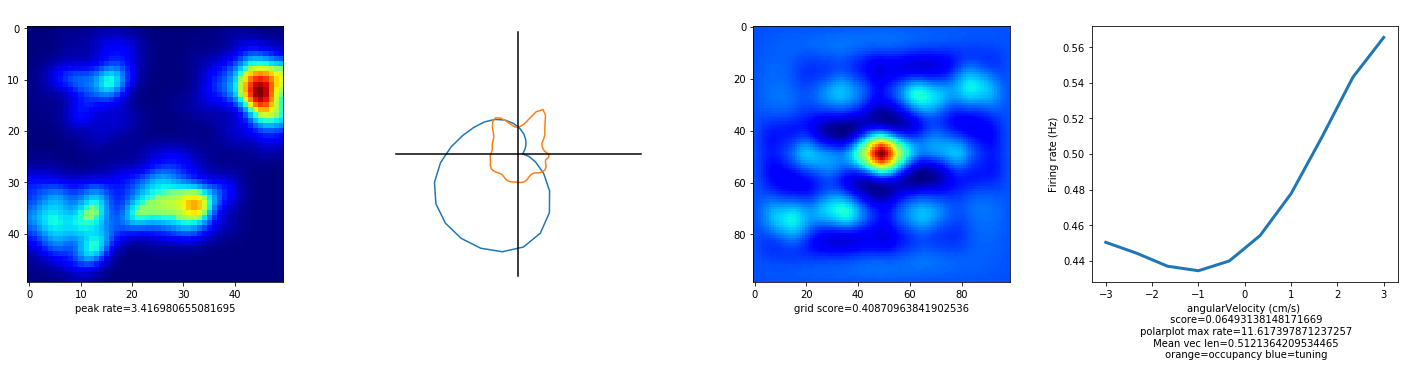

In [79]:
gridScoreSorted=cellMetadata[(cellMetadata["HDModulated"]==1)&(cellMetadata["angularVelocityModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n score="+str(gridScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("Grid_x_HD_angularVelocity_cell"+str(cell+1)+".svg")

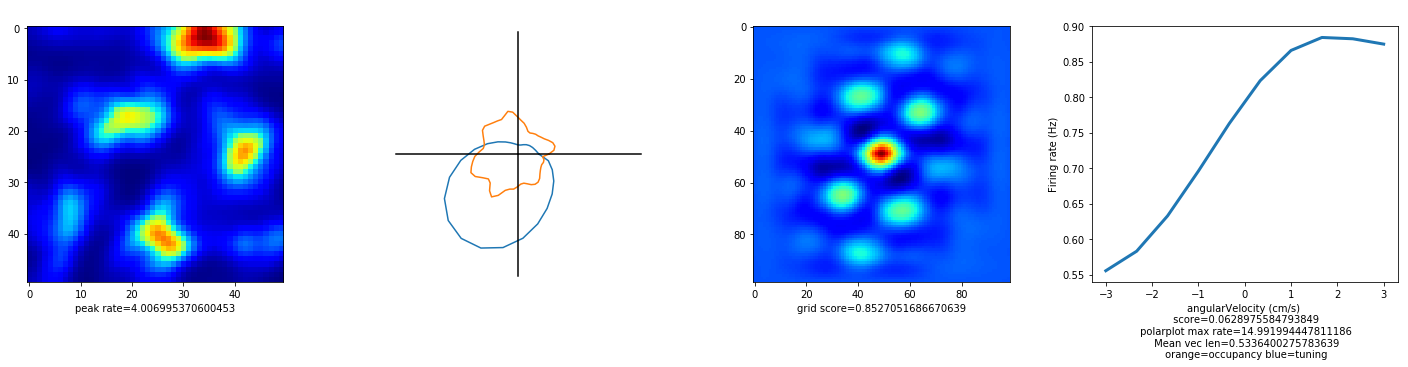

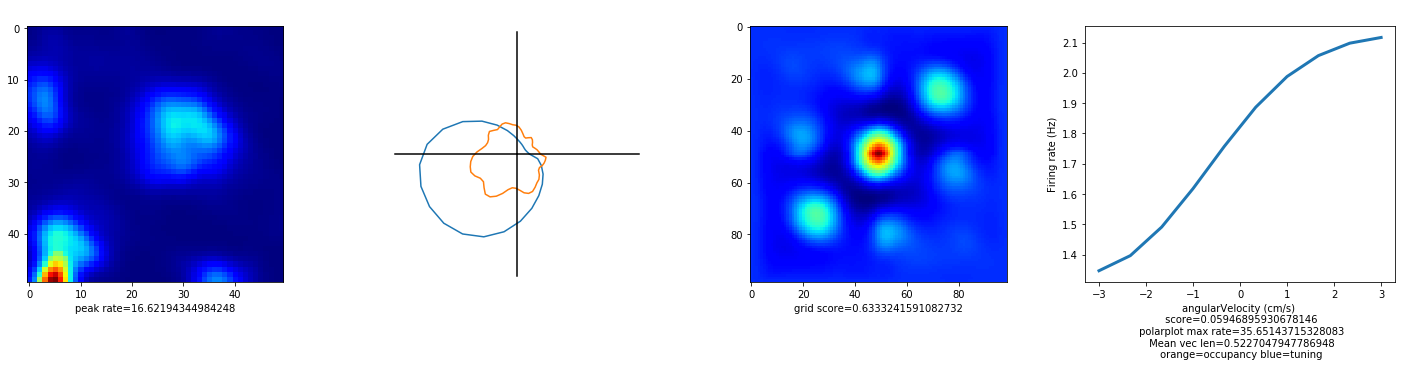

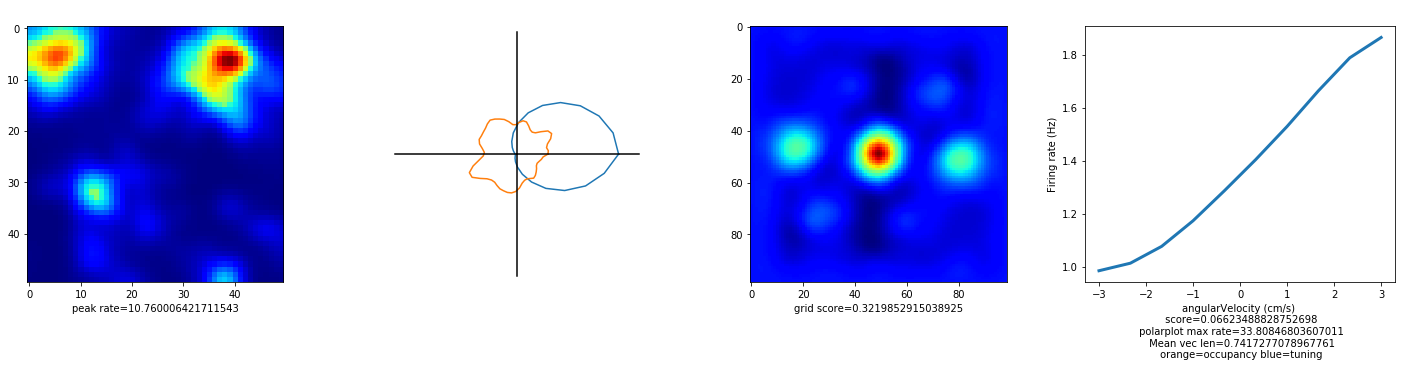

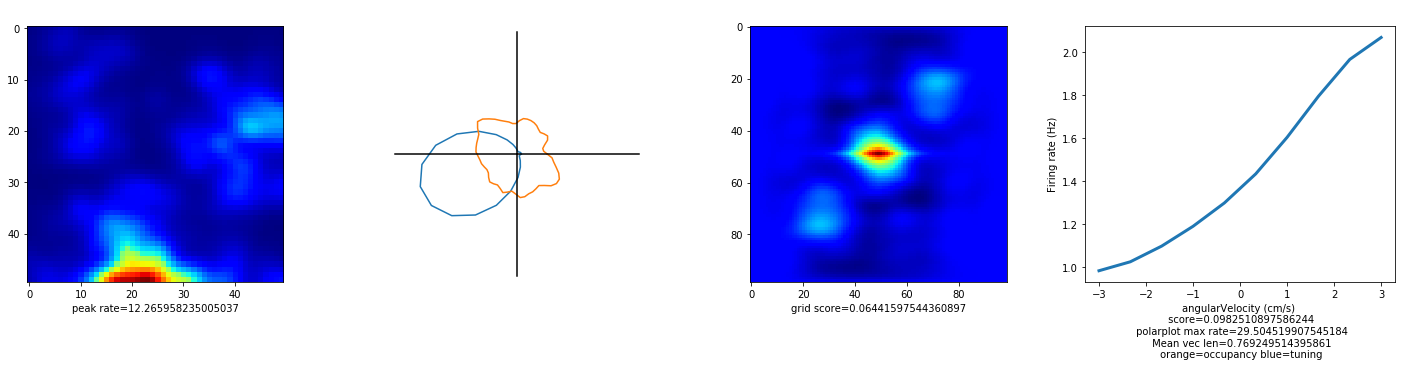

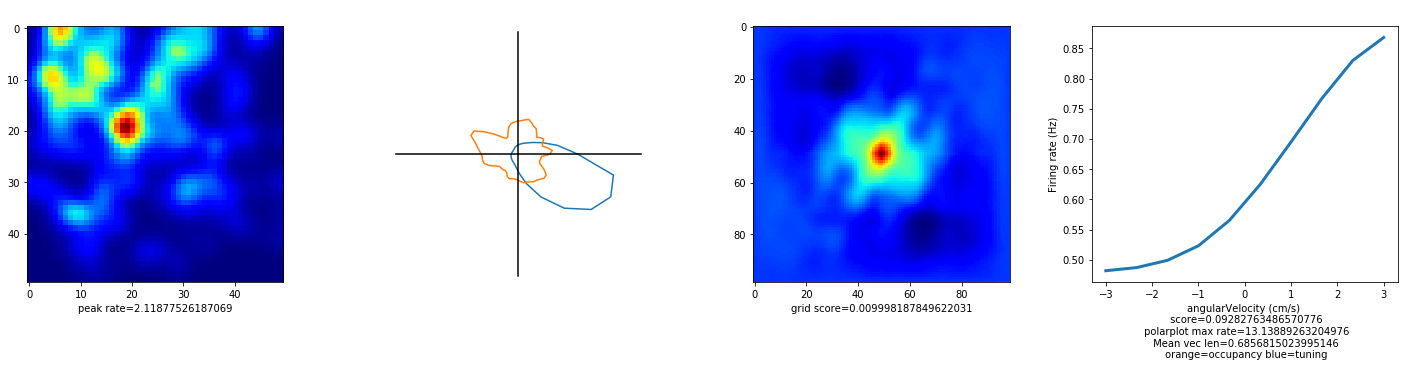

In [82]:
MECcells=cellMetadata[cellMetadata["region"]=="MEC"]
gridScoreSorted=MECcells[(MECcells["HDModulated"]==1)&(MECcells["angularVelocityModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n score="+str(gridScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("MEC_Grid_x_HD_angularVelocity_cell"+str(cell+1)+".svg")

## CCW AV

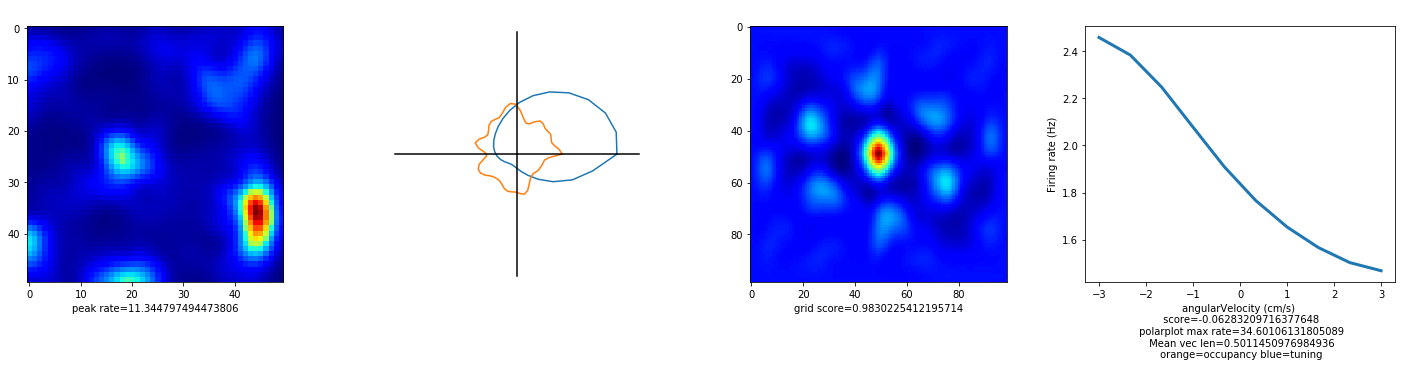

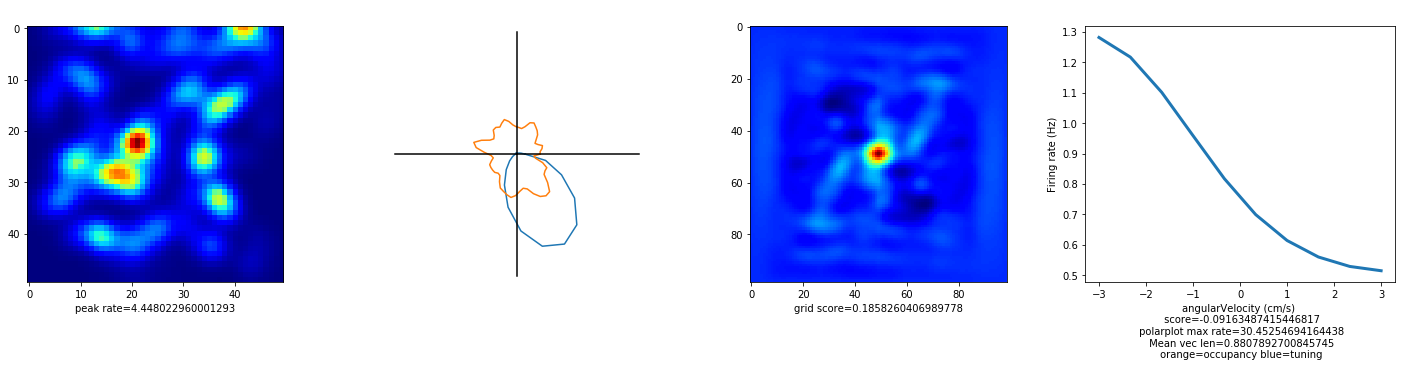

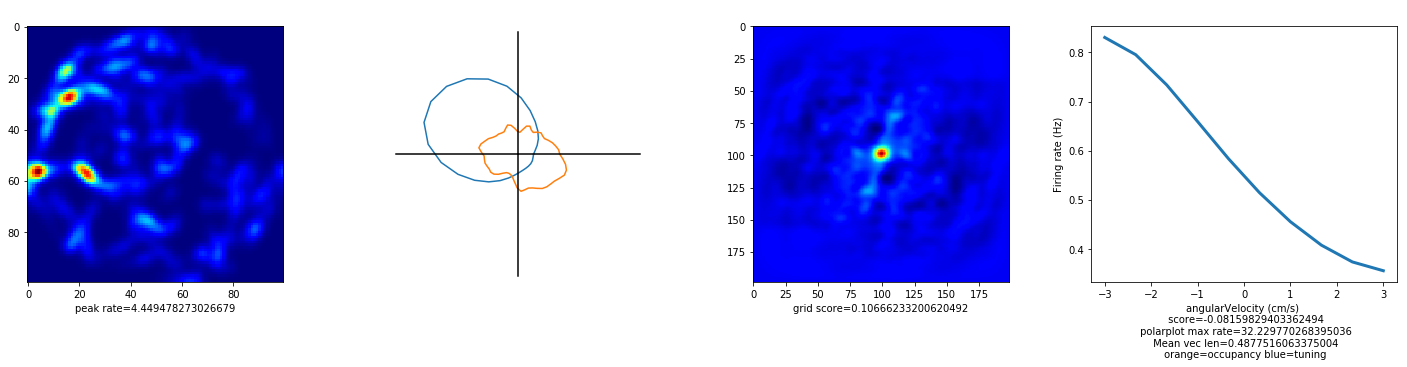

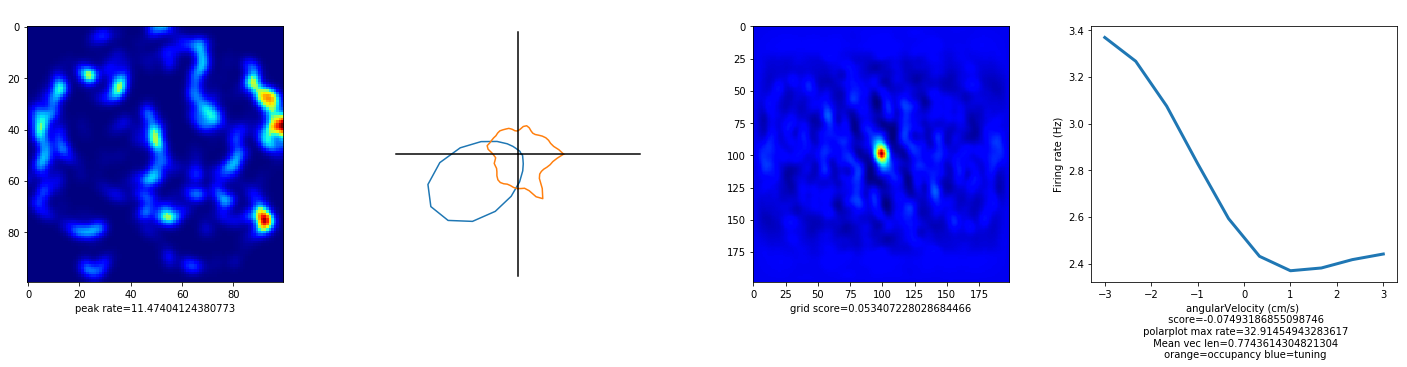

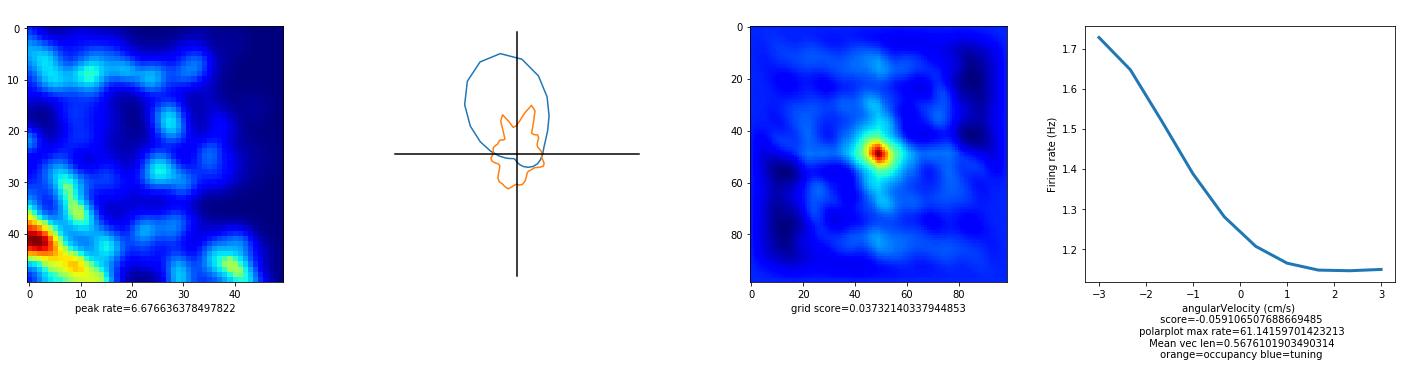

In [83]:
gridScoreSorted=cellMetadata[(cellMetadata["HDModulated"]==1)&(cellMetadata["angularVelocityCCWModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n score="+str(gridScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("Grid_x_HD_angularVelocityCCW_cell"+str(cell+1)+".svg")

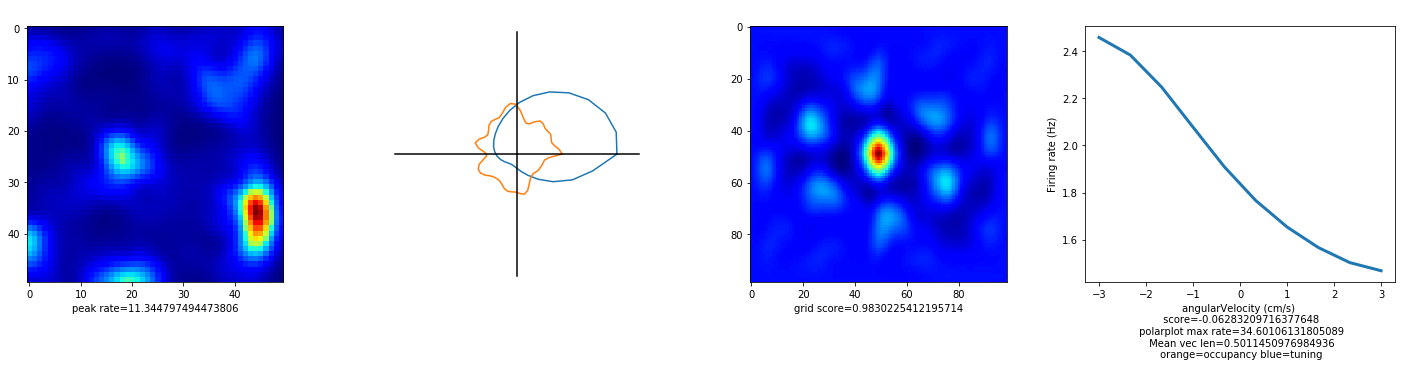

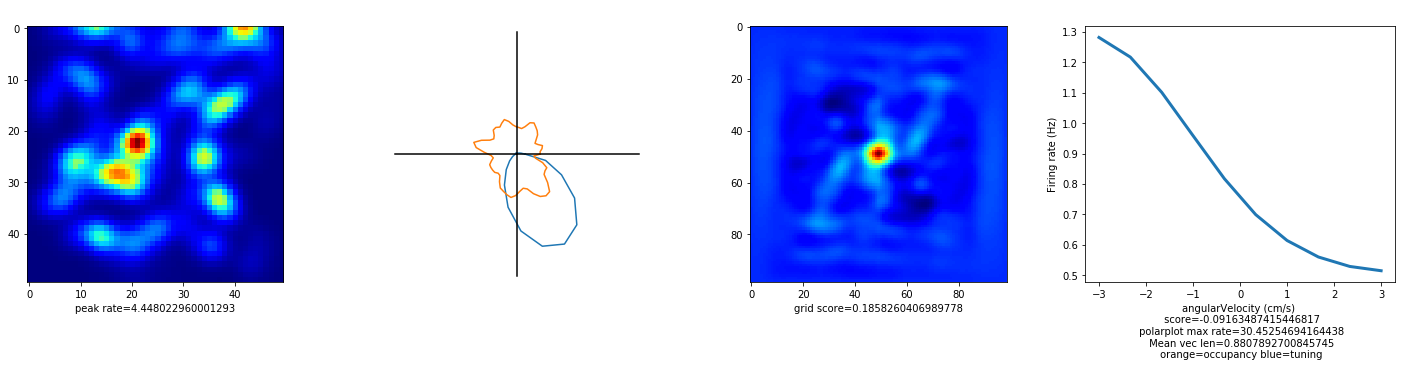

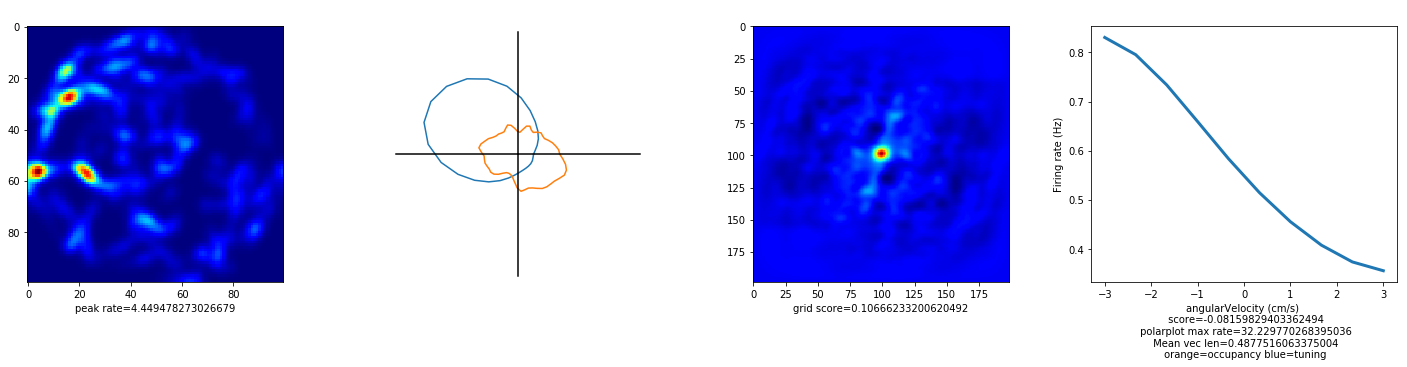

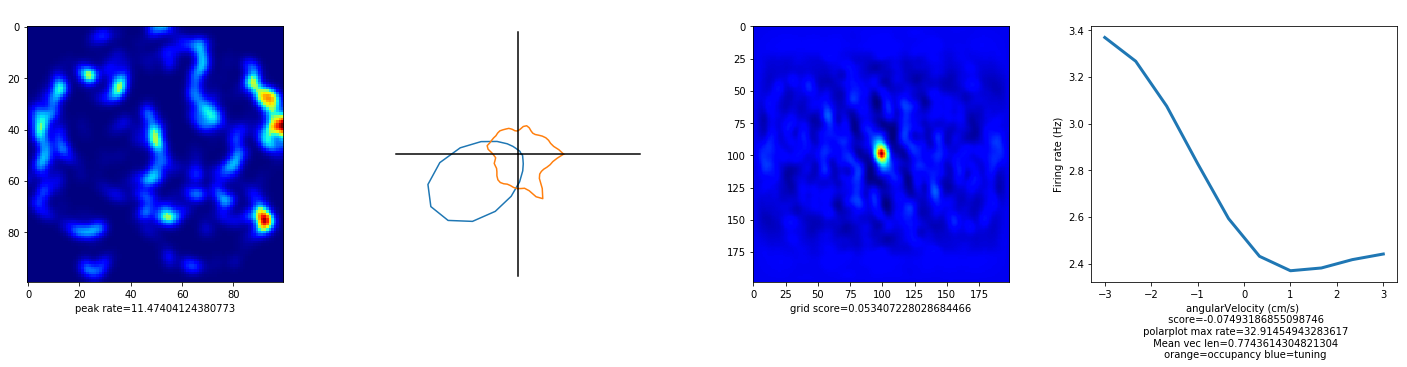

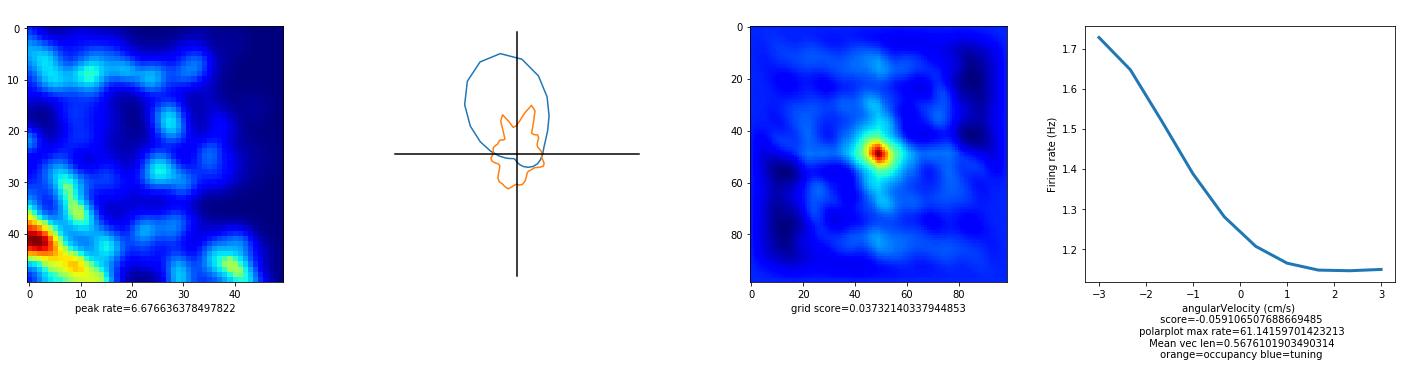

In [86]:
PRScells=cellMetadata[cellMetadata["region"]=="PrS"]
gridScoreSorted=PRScells[(PRScells["HDModulated"]==1)&(PRScells["angularVelocityCCWModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n score="+str(gridScoreSorted["angularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("PRS_Grid_x_HD_angularVelocityCCW_cell"+str(cell+1)+".svg")

## ABS AV

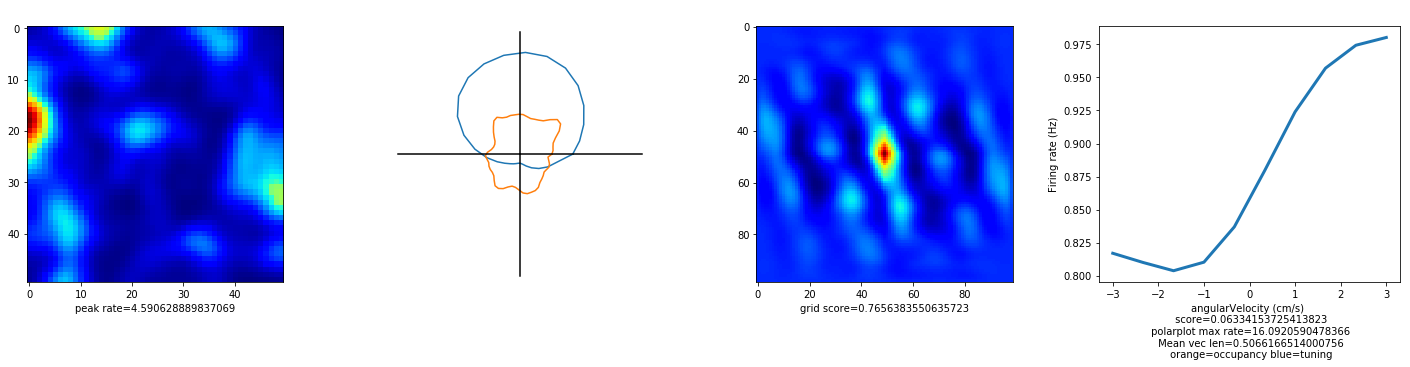

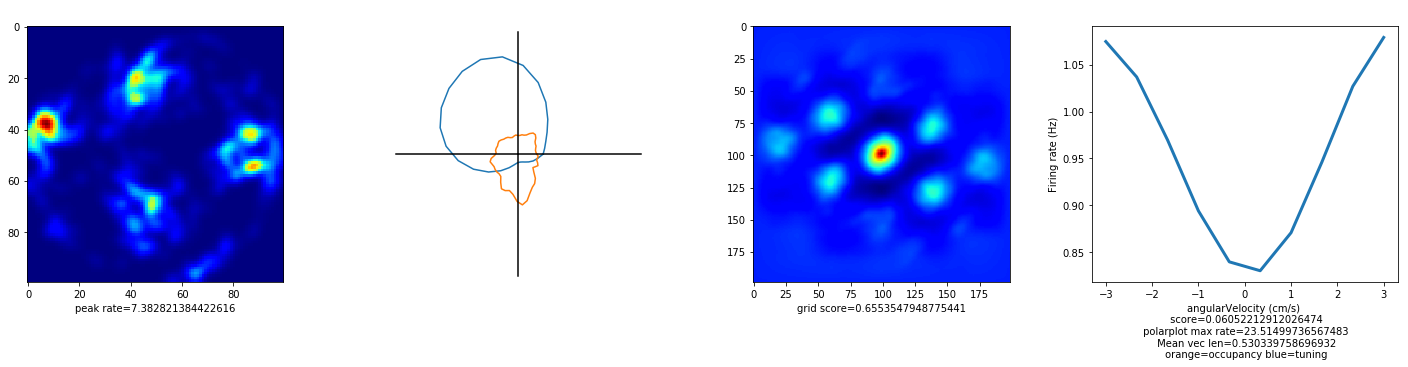

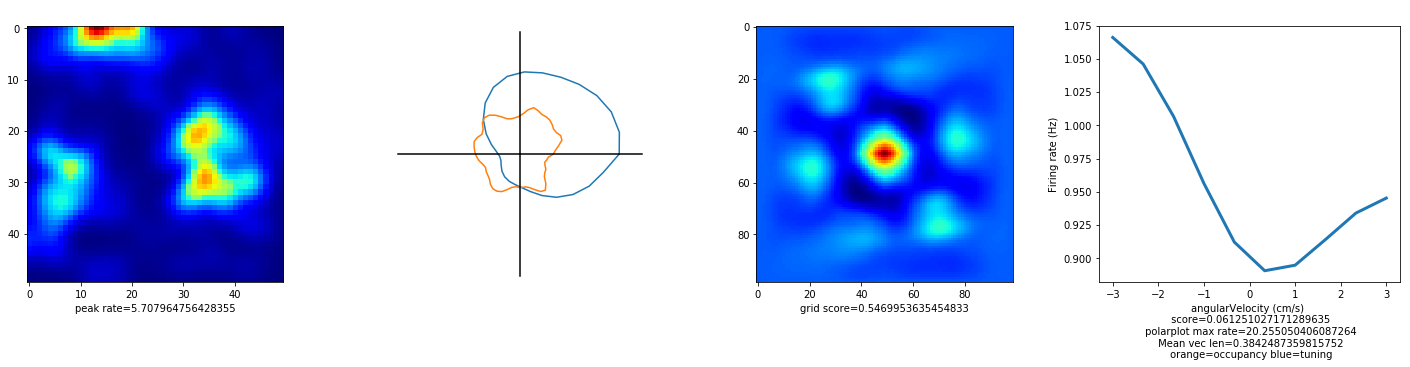

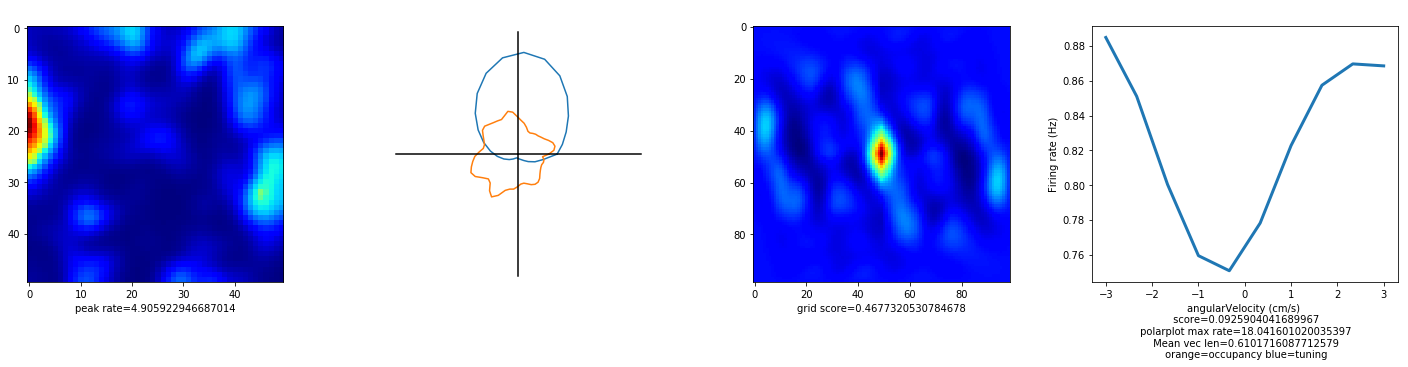

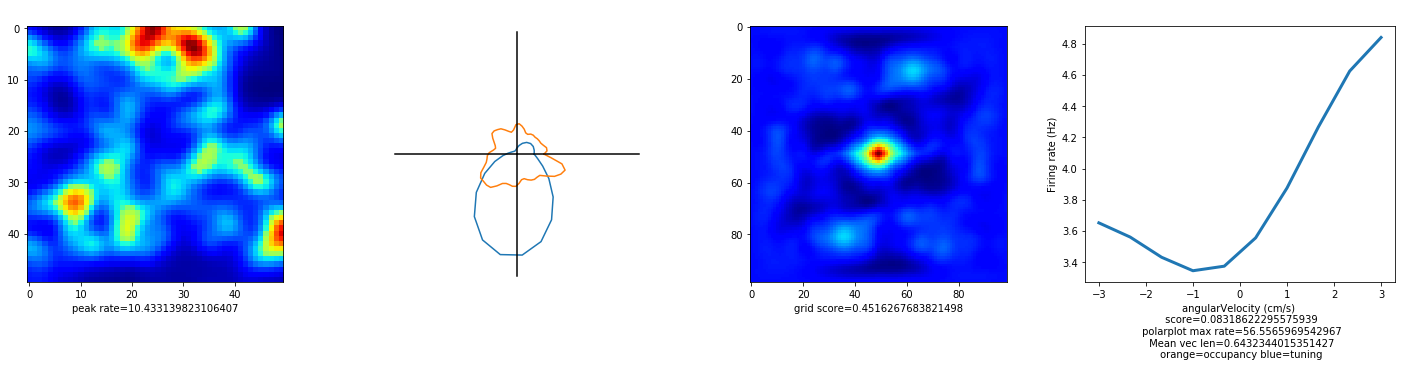

In [87]:
gridScoreSorted=cellMetadata[(cellMetadata["HDModulated"]==1)&(cellMetadata["absAngularVelocityModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n score="+str(gridScoreSorted["absAngularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("Grid_x_HD_ABSangularVelocity_cell"+str(cell+1)+".svg")

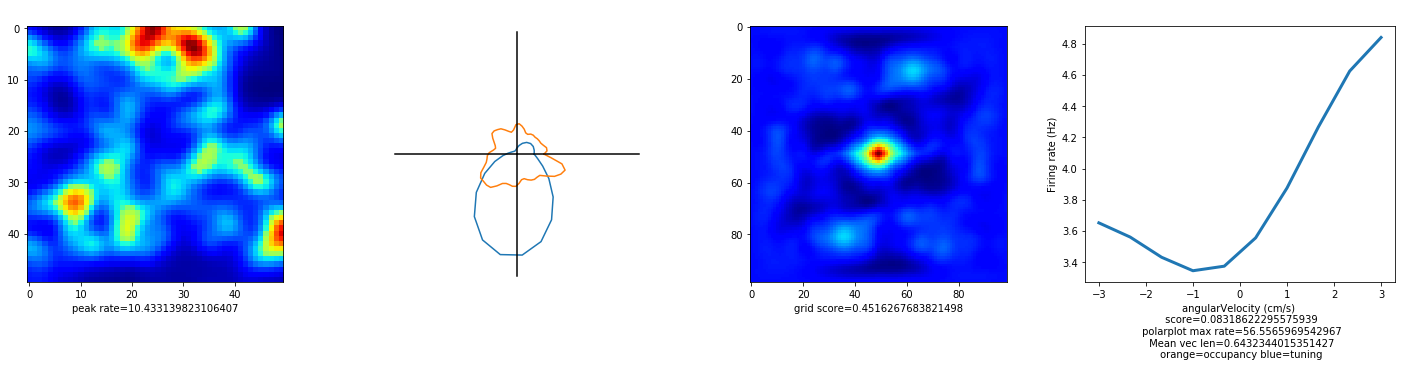

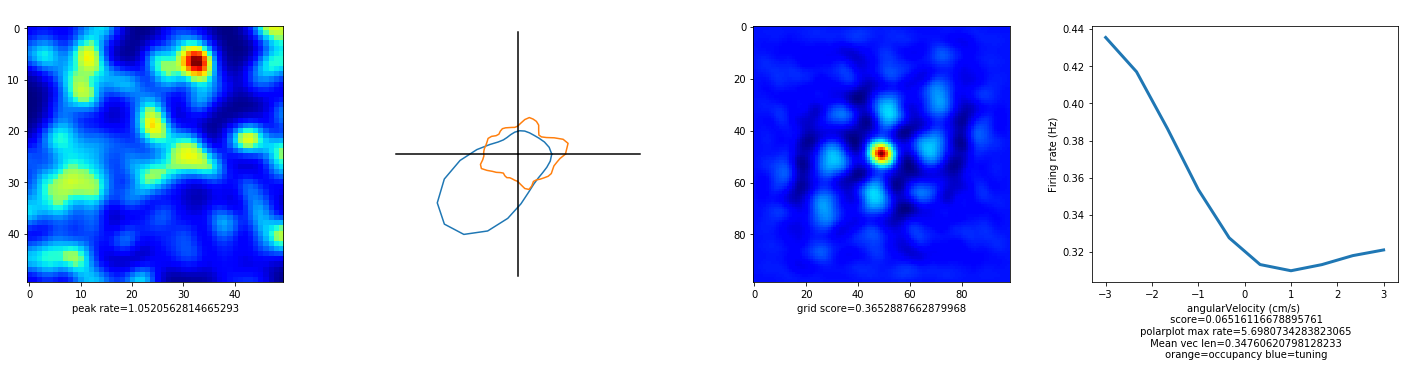

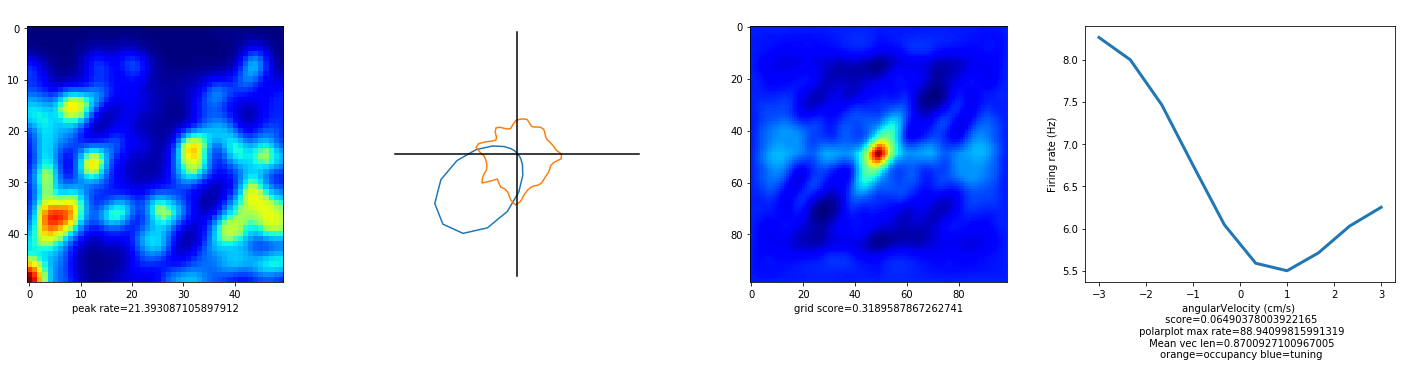

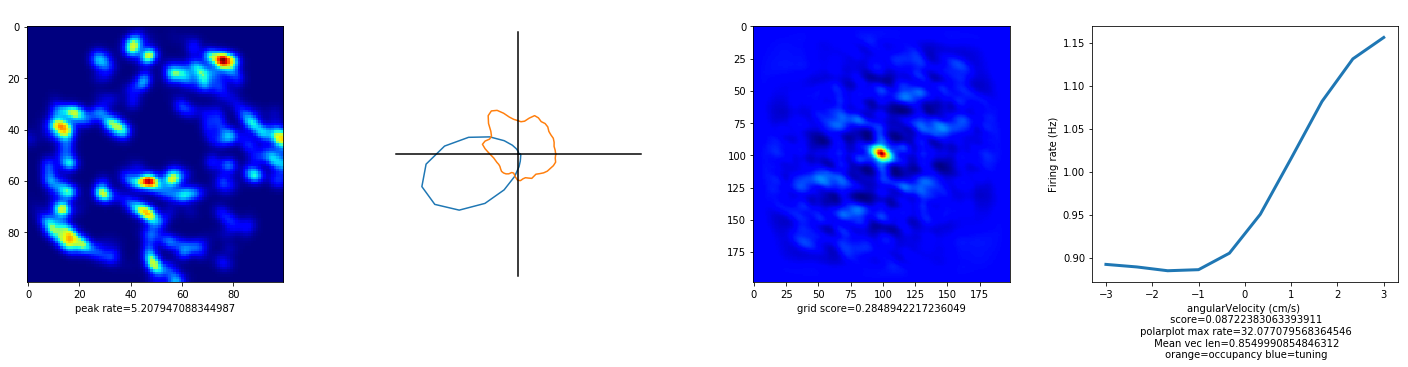

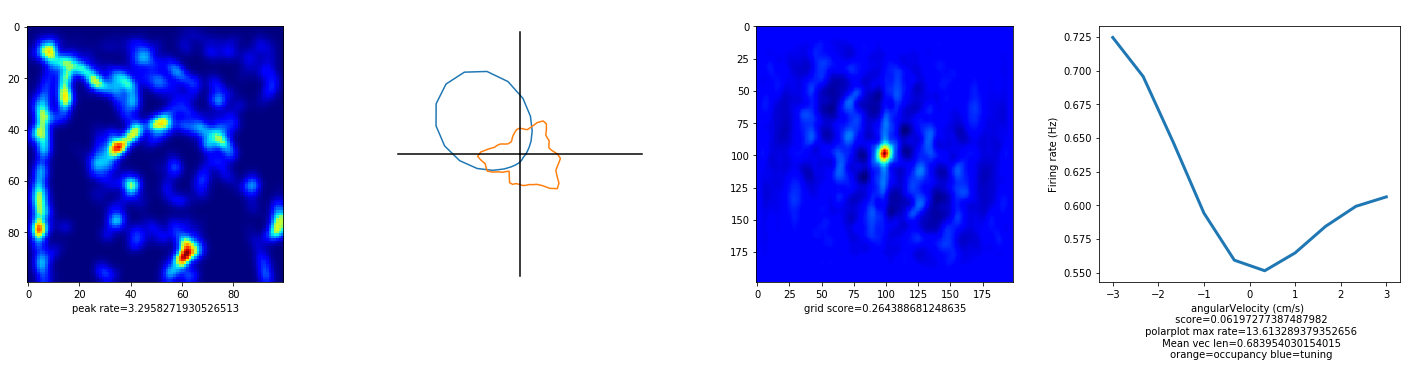

In [92]:
PRScells=cellMetadata[cellMetadata["region"]=="PrS"]
gridScoreSorted=PRScells[(PRScells["HDModulated"]==1)&(PRScells["absAngularVelocityModulated"]==1)].sort_values("gridScore",ascending=False)

interval = np.hstack([np.linspace(0, 0.4), np.linspace(0.5, 1)])
colors = plt.cm.jet(interval)
cmap = LinearSegmentedColormap.from_list('name', colors)

for cell in range(5):
    r=rate[gridScoreSorted.index[cell]].values
    x=xs[gridScoreSorted["trialIndex"][cell]].values
    y=ys[gridScoreSorted["trialIndex"][cell]].values
    s=angularVelocity[gridScoreSorted["trialIndex"][cell]].values
    hd=HD[gridScoreSorted["trialIndex"][cell]].values
    dim=trialMetadata[trialMetadata["trialIndex"]==gridScoreSorted["trialIndex"][cell]]["dim"].values
    rate_map=calculatePlotRatemap(x,y,r,dim)
    ac=autocorrelation(rate_map, mode='full', normalize=True)/len(rate_map.flatten())
    figure(figsize(20,5))
    ax=subplot(1,4,1)
    rim=ax.imshow(rate_map,cmap=cmap)
    #colorbar(rim)
    xlabel("peak rate="+str(max(rate_map.flatten())))
    ax=subplot(1,4,3)
    acim=ax.imshow(ac,cmap=cm.jet)
    xlabel("grid score="+str(gridScoreSorted["gridScore"][cell]))
    ax=subplot(1,4,2, projection='polar')
    theta,tuning=calculateHDtuning(hd,r)
    ax.plot(theta,tuning)
    theta,occupancy=calculateOccupancy(hd)
    ax.plot(theta,occupancy*(max(tuning)/2.0)/max(occupancy))
    ax.plot([0]*linspace(0,1.2*max(tuning)),linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([pi for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    ax.plot([3*pi/2 for x in linspace(0,1.2*max(tuning))],linspace(0,1.2*max(tuning)),c="k")
    axis("off")
    #colorbar(acim)
    ax=subplot(1,4,4)
    bad = ~np.logical_or(np.isnan(r), np.isnan(s))
    a=np.compress(bad, s)  
    b=np.compress(bad, r)
    x=linspace(-3,3,10)
    y=stats.binned_statistic(a,b, statistic='mean', bins=10, range=[-3,3])[0]
    y1=gaussian_filter(y,2)
    plot(x,y1,linewidth=3)
    xlabel("angularVelocity (cm/s) \n score="+str(gridScoreSorted["absAngularVelocityScore"][cell])+"\n polarplot max rate="+str(max(r))+"\n Mean vec len="+str(gridScoreSorted["meanVecLen"].values[cell])+"\n orange=occupancy blue=tuning")
    ylabel("Firing rate (Hz)")
    tight_layout()
    savefig("PRS_Grid_x_HD_ABSangularVelocity_cell"+str(cell+1)+".svg")